In [1]:
from lemaitre import georges
georges.setup_logger(level='DEBUG')
from lemaitre import bandpasses

filterlib = bandpasses.get_filterlib()

2025-07-18 14:49:40 DEBUG lemaitre.georges.logger - logger set to DEBUG level
2025-07-18 14:49:41 WARNING py.warnings - /cfs/home/angi0819/conda/envs/lemaitre/lib/python3.12/site-packages/sparse_dot_mkl/_mkl_interface/__init__.py:147: RuntimeWarning: MKL_INTERFACE_LAYER value LP64,GNU invalid; set 'ILP64' or 'LP64'
  _warnings.warn(

2025-07-18 14:49:43 DEBUG lemaitre.bandpasses.flibs - found 1 versions of lemaitre filterlib in cache
2025-07-18 14:49:43 INFO lemaitre.bandpasses.flibs - loading lemaitre filterlib from /cfs/home/angi0819/.cache/bbf/lemaitre_flib.default.dbe7e2486759aa0fb2f9f3172b4be8ca2a4461db77271d85f279f2ac2aea0c8f.pkl


In [2]:
import skysurvey
import numpy as np
import sncosmo
import pandas
from src import *
from tqdm.auto import tqdm
import jax.numpy as jnp
import pickle

2025-07-18 14:49:44 INFO root - sparse_dot_mkl found. Building hessian should be faster.
2025-07-18 14:49:44 INFO nacl.minimize - sparse_dot_mkl found. Building hessian should be faster.
2025-07-18 14:49:44 INFO nacl.models.salt2.lightcurves - sparse_dot_mkl found. Building hessian should be faster.
2025-07-18 14:49:44 DEBUG lemaitre.bandpasses.flibs - found 1 versions of lemaitre filterlib in cache
2025-07-18 14:49:44 INFO lemaitre.bandpasses.flibs - loading lemaitre filterlib from /cfs/home/angi0819/.cache/bbf/lemaitre_flib.default.dbe7e2486759aa0fb2f9f3172b4be8ca2a4461db77271d85f279f2ac2aea0c8f.pkl
2025-07-18 14:49:46 INFO arviz.preview - arviz_base not installed
2025-07-18 14:49:46 INFO arviz.preview - arviz_stats not installed
2025-07-18 14:49:46 INFO arviz.preview - arviz_plots not installed
INFO:2025-07-18 14:49:46,359:jax._src.xla_bridge:867: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or direct

import warnings
from iminuit.warnings import IMinuitWarning

warnings.filterwarnings("ignore", category=IMinuitWarning)

In [3]:
%matplotlib inline

In [4]:
survey_colors = dict(ZTF="tab:blue", SNLS="tab:orange", HSC="tab:green")

In [5]:
z_max = 0.11677295
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(name="2m++", H0=68.1, Om0=0.306)

## Test georges

### Georges input formatting

In [8]:
lc_georges = pandas.read_parquet("/cfs/data/angi0819/Projet_LPNHE/mocks_madeleine/lc_data_0.parquet")

In [9]:
sn_georges = pandas.read_parquet("/cfs/data/angi0819/Projet_LPNHE/mocks_madeleine/sn_data_0.parquet")

In [9]:
spec_georges = pandas.read_parquet("/cfs/data/angi0819/Projet_LPNHE/mocks_madeleine/spec_data_0.parquet")

In [16]:
data_ztf, lc_ztf = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_2M++.pkl", survey='ZTF')
data_hsc, lc_hsc = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_hsc.pkl", survey='HSC')
data_snls, lc_snls = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_snls.pkl", survey='SNLS')

In [17]:
data = pandas.concat([data_ztf, data_snls, data_hsc])
lc = pandas.concat([lc_ztf, lc_snls, lc_hsc]) 

In [18]:
data.rename(columns={"t0":"tmax"}, inplace=True)
data.reset_index(drop=True, inplace=True)
data["IAU"]=np.NaN
data["valid"]=1
data["sig_int"]=0.


In [19]:
data[sn_georges.columns].to_parquet("/cfs/data/angi0819/Projet_LPNHE/georges_inputs/full_mock/sn_data_0.parquet")

In [20]:
lc.rename(columns=dict(time="mjd", zpsys="magsys"), inplace=True)

In [21]:
ids = lc.groupby(["sn", "band"]).flux.count()

In [22]:
ids = pandas.Series(data = np.arange(len(ids)), index= ids.index)

In [23]:
lc['lc'] = ids.loc[zip(lc.sn, lc.band)].values

In [24]:
lc[['mag_sky', 'seeing', 'exptime', 'ccd', 'amp',]] = np.NaN
lc['valid'] = 1
lc['errorsnake'] = 0.

In [25]:
lc['mjd_round'] = np.floor(lc.mjd)

In [26]:
lc.drop(columns=['fieldid', 'survey'], inplace=True)

##### rcid and ccd pos

In [27]:
sn_miss = lc[np.isnan(lc.rcid)].sn.unique()
missing_rcid = pandas.DataFrame(np.random.randint(1,37, len(sn_miss)), index = sn_miss)
lc.loc[sn_miss, 'rcid'] = missing_rcid.loc[lc.loc[sn_miss].sn].values
lc.rcid = lc.rcid.astype(int)
nb_rcid = lc.groupby(['sn', 'rcid']).rcid.nunique()


In [28]:
pos = pandas.DataFrame(np.random.randint(1,3001, (len(nb_rcid), 2)), index=nb_rcid.index, columns=['x', 'y'])

In [29]:
lc["x"] = pos.loc[zip(lc.sn, lc.rcid), "x"].values
lc["y"] = pos.loc[zip(lc.sn, lc.rcid), "y"].values

In [30]:
lc.rename(columns={"rcid":"sensor_id"}, inplace=True)

In [31]:
lc.reset_index(drop=True, inplace=True)

In [32]:
lc.band.unique()

array(['ztf::g', 'ztf::r', 'ztf::i', 'MEGACAM6::g', 'MEGACAM6::i',
       'MEGACAM6::i2', 'MEGACAM6::r', 'MEGACAM6::z', 'hsc::Y', 'hsc::i2',
       'hsc::g', 'hsc::r2', 'hsc::z'], dtype=object)

In [33]:
lc_georges.band.unique()

array(['hsc::g', 'hsc::Y', 'hsc::i2', 'hsc::r2', 'hsc::z', 'MEGACAM6::g',
       'MEGACAM6::i', 'MEGACAM6::r', 'MEGACAM6::z', 'MEGACAM6::i2',
       'ztf::r', 'ztf::g', 'ztf::i'], dtype=object)

In [34]:
lc[lc_georges.columns].to_parquet("/cfs/data/angi0819/Projet_LPNHE/georges_inputs/full_mock/lc_data_0.parquet")

In [35]:
spec_ztf = pandas.read_csv("/cfs/data/angi0819/Projet_LPNHE/spectra_2M++.csv").drop(columns=['x0','x1','c','t0','mwebv','z','flux_true','snid'])
spec_ztf['survey'] = 'ZTF'
spec_hsc = pandas.read_csv("/cfs/data/angi0819/Projet_LPNHE/spectra_hsc.csv").drop(columns=['x0','x1','c','t0','mwebv','z','flux_true','snid'])
spec_hsc['survey'] = 'HSC'
spec_snls = pandas.read_csv("/cfs/data/angi0819/Projet_LPNHE/spectra_snls.csv").drop(columns=['x0','x1','c','t0','mwebv','z','flux_true','snid'])
spec_snls['survey'] = 'SNLS'
shift_sp_ztf, shift_sp_snls = spec_ztf.spec.max()+1, spec_snls.spec.max()+1
spec_snls.spec += shift_sp_ztf
spec_hsc.spec += shift_sp_ztf + shift_sp_snls
spec = pandas.concat([spec_ztf, spec_snls, spec_hsc])
spec['name'] = spec.survey + '_' + spec.sn.astype(str)
spec.set_index('name', drop=False, inplace=True)

In [36]:
spec.spec = spec.survey + '_spec_' + spec.spec.astype(str)

In [37]:
spec.sn = spec.name

In [38]:
spec.rename(columns=dict(time='mjd'), inplace=True)

In [39]:
spec['i_basis']= -1

In [40]:
spec.reset_index(inplace=True, drop=True)
spec.drop(columns=['survey'], inplace=True)

In [41]:
spec[spec_georges.columns].to_parquet("/cfs/data/angi0819/Projet_LPNHE/georges_inputs/full_mock/spec_data_0.parquet")

## SNe Generation from 2M++

### ZTF

In [261]:
class SNeIa_full_bgs(Transient):

    _KIND = "SNIa"
    _RATE = 2.35 * 10**4 # /yr/Gpc^3 Perley 2020
    _COSMOLOGY = cosmo

    def __init__(self,
                 path=None,
                 filename="Uchuu.csv",
                 salt_path=None,
                 date_range=[58179, 59215],
                 zmax=0.06,
                 extinction=True):
        super().__init__()
        # {'model': func, 'prop': dict, 'input':, 'as':}
        self.galaxy_positions = load_bgs(path=path, filename=filename)
        self.set_model(dict(
            x1={"func": SNeIaStretch.nicolas2021},
            c={"func": SNeIaColor.intrinsic_and_dust},
            t0={"func": np.random.uniform, "kwargs": {"low": date_range[0], "high": date_range[1]}},
            magabs={
                "func": SNeIaMagnitude.tripp1998,
                "kwargs": {"x1": "@x1", "c": "@c", "mabs": -19.3, "sigmaint": 0.10},
            },
            magobs={
                "func": "magabs_to_magobs",
                "kwargs": {"z": "@z_cosmo", "magabs": "@magabs"},
            },
            x0={
                "func": "magobs_to_amplitude", 
                "kwargs": {"magobs": "@magobs", "param_name": "x0"},
            },
            radecz={
                "func": rand_positions,
                "kwargs": {"positions": self.galaxy_positions, 'zcut': zmax},
                "as": ["ra", "dec", "z", "host_id", "z_cosmo"],
            },
        ))
        
        if salt_path:
            source = sncosmo.SALT2Source(modeldir=salt_path,
                                         m0file='nacl_m0_test.dat',
                                         m1file='nacl_m1_test.dat',
                                         clfile='nacl_color_law_test.dat')
        else:
            source = sncosmo.get_source('salt2', version='2.4')
        
        if extinction:
            model = sncosmo.Model(source=source, effects=[sncosmo.CCM89Dust()], effect_names=['mw'], effect_frames=['obs'])
            self.set_model({**self.model.model,
                            "mwebv":{"func": milkyway.get_mwebv, "kwargs": {"ra": "@ra", "dec": "@dec"}},})
        else:
            model= sncosmo.Model(source=source)
        self.set_template(model)
        
        self.area=self.get_effective_area()
        # USE THIS AREA WHEN DRAWING TO ACCOUNT FOR THE CATALOG FOOTPRINT
        # e.g. SNeIa_full_bgs().draw(skyarea=SNeIa_full_bgs().area)

    def get_effective_area(self):
        nside = 2**(np.int32(np.log2(np.sqrt(self.galaxy_positions.shape[0]/(10*12))))-1)
        id_bgs = ang2pix(theta=np.pi / 2 - self.galaxy_positions["dec"] * np.pi / 180,
                            phi=self.galaxy_positions["ra"] * np.pi / 180,
                            nside=nside)

        mask = np.zeros(nside2npix(nside), dtype=bool)
        for i in id_bgs:
            mask[i] = True

        return np.sum(mask)*nside2pixarea(nside, degrees=True)


In [262]:
survey=extract_ztf()

2025-07-07 17:33:30 INFO ZTFxUchuu - Loading ZTF survey


In [277]:
snia = SNeIa_full_bgs(filename="/cfs/data/angi0819/Projet_LPNHE/2M++_BORG/reduced_hbt/halos_highres_0.csv",
                      date_range=survey.date_range,
                      zmax=0.1,)
# snia.cosmology=cosmo
_ = snia.draw(tstart=survey.date_range[0], tstop=survey.date_range[1],
              zmax=0.1,
              skyarea=snia.area,
              inplace=True)

float32_cols = list(snia.data.select_dtypes(include='float32'))
snia.data[float32_cols] = snia.data[float32_cols].astype('float64')

In [280]:
import os
nthreads=64
os.environ['OMP_NUM_THREADS'] = str(nthreads)
os.environ['MKL_NUM_THREADS'] = str(nthreads)
os.environ['OPENBLAS_NUM_THREADS'] = str(nthreads)
os.environ['NUMEXPR_NUM_THREADS'] = str(nthreads)


In [285]:
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey, incl_error=True, discard_bands=True)
float32_cols = list(dset.data.select_dtypes(include='float32'))
dset.data[float32_cols] = dset.data[float32_cols].astype('float64')

2025-07-07 17:44:14 WARNING py.warnings - /cfs/home/angi0819/conda/0.2/envs/lemaitre/lib/python3.10/site-packages/ztffields/projection.py:157: UserWarning: cannot use dask_geopandas with MultiIndex fields dataframe
  warnings.warn("cannot use dask_geopandas with MultiIndex fields dataframe")



In [295]:
from skysurvey import lcfit

In [301]:
dset.data.rename(columns=dict(mjd='time'), inplace=True)

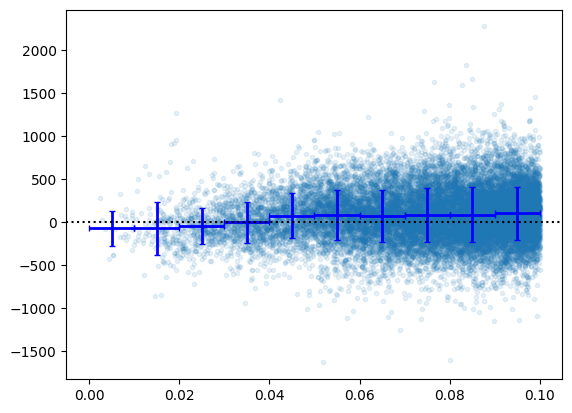

In [304]:
z_max = 0.1
n_bins = 10
width = z_max/n_bins
bounds = np.linspace(0.00, z_max-width, n_bins)
pv = (dset.targets.data.z - dset.targets.data.z_cosmo)*1e-3*c/(1+dset.targets.data.z_cosmo)
in_bins = [(dset.targets.data.z > z_min) & (dset.targets.data.z < z_min + width) for z_min in bounds]
plt.scatter(dset.targets.data.z,
            pv,
            marker=".",
            alpha=0.1,
           )


plt.errorbar(bounds + width/2,
             [pv[filt].mean() for filt in in_bins],
             yerr=[pv[filt].std() for filt in in_bins],
             xerr=width/2,
             linestyle='',
             color='blue',
             linewidth=2,
             alpha=1,
             capsize=2)
plt.axhline(0, color="k", linestyle=":")

In [305]:
with open('/cfs/data/angi0819/Projet_LPNHE/dataset_2M++.pkl', 'wb') as file:
    pickle.dump(dset.targets.data, file)
    pickle.dump(dset.data, file)

### HSC/SNLS

In [325]:
class SNeIa( skysurvey.SNeIa ):

    _COSMOLOGY=cosmo
    
snia = SNeIa()


In [326]:
survey = extract_hsc()

2025-07-07 18:00:56 WARNING py.warnings - /cfs/home/angi0819/conda/0.2/envs/lemaitre/lib/python3.10/site-packages/skysurvey/survey/polygon.py:167: UserWarning: You do not have polars installed. conda/pip install polars. falling back to pandas backend
  warnings.warn("You do not have polars installed. conda/pip install polars. falling back to pandas backend")



In [327]:
from skysurvey.effects.milkyway import mwebv_model
snia.update_model(t0={"func":np.random.uniform,
                      'kwargs':{'low':survey.date_range[0], 'high':survey.date_range[1]}}, 
                  redshift={"kwargs": {'zmax': 1.6,}, 'as':'z'},
                  **mwebv_model)

In [328]:
_=snia.draw(tstart=survey.date_range[0], tstop=survey.date_range[1],
          skyarea=survey.get_skyarea().buffer(0.01), zmax=1.6,
          inplace=True)
float32_cols = list(snia.data.select_dtypes(include='float32'))
snia.data[float32_cols] = snia.data[float32_cols].astype('float64')


In [329]:
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey, discard_bands=True)

float32_cols = list(dset.data.select_dtypes(include='float32'))
dset.data[float32_cols] = dset.data[float32_cols].astype('float64')

2025-07-07 18:01:11 WARNING py.warnings - /cfs/home/angi0819/conda/0.2/envs/lemaitre/lib/python3.10/site-packages/skysurvey/dataset.py:683: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  this_survey = gsurvey_indexed.get_group(index_).copy()



In [332]:
dset.targets.data.dtypes

z           float64
x1          float64
c           float64
t0          float64
ra          float64
dec         float64
magabs      float64
mwebv       float64
magobs      float64
x0          float64
template     object
dtype: object

In [333]:
dset.data.dtypes

fieldid       int64
band         object
mjd         float64
zp          float64
zpsys        object
gain        float64
skynoise    float64
flux        float64
fluxerr     float64
dtype: object

In [334]:
with open('/cfs/data/angi0819/Projet_LPNHE/dataset_hsc.pkl', 'wb') as file:
    pickle.dump(dset.targets.data, file)
    pickle.dump(dset.data, file)

### Spectra

In [373]:
data, lc = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_2M++.pkl", survey='ZTF')

In [381]:
lc = lc[(lc.mjd.between(data.loc[lc.sn, 't0'] - 20, data.loc[lc.sn, 't0'] + 50))].copy()
lc['valid'] = (lc.flux/lc.fluxerr>5)

In [382]:
# Select SN on : >=5 detections in >=2 bands
goods_sn = (lc[lc.valid].groupby(["sn"]).band.nunique() >= 2) & \
           (lc[lc.valid].groupby(["sn"])['flux'].count() >= 5) & \
           (lc[lc.valid][lc[lc.valid].mjd < data.loc[lc[lc.valid].sn, "t0"]].groupby("sn").flux.count() >= 2) & \
           (lc[lc.valid][lc[lc.valid].mjd > data.loc[lc[lc.valid].sn, "t0"]].groupby("sn").flux.count() >= 2)

In [383]:
lc = lc[lc.sn.isin(goods_sn[goods_sn].index)]

data = data[data.sn.isin(lc.sn.unique())]

In [384]:
snia = skysurvey.SNeIa.from_data(data)
snia.update_model(#t0={"func":np.random.uniform, 'kwargs':{'low':survey.date_range[0], 'high':survey.date_range[1]}},
                  redshift={"kwargs": {'zmax':1.6,}, 'as':'z'},
                  mwebv={"func": skysurvey.effects.milkyway.get_mwebv, "kwargs": {"ra": "@ra", "dec": "@dec"}},)

source = sncosmo.get_source('salt2', version='2.4')
model= sncosmo.Model(source=source,effects=[sncosmo.CCM89Dust()],effect_names=['mw'],effect_frames=['obs'])

snia.set_template(model)

In [385]:
output = lc.loc[data.index].join(data.drop(columns=["sn", "survey"])).drop(columns=['template'])
output['snid'] = output.index

In [386]:
output.rename(columns=dict(mjd="time"), inplace=True)

In [387]:
from mocksurvey.simulations import (
    get_luminosity_distance,
    get_effective_wavelength,
    get_snr,
    build_band_index,
    discard_small_snr,
    discard_skysurvey_flux,
    eliminate_points_not_in_model,
    get_trueflux_and_amplitude,
    get_sn_position,
)

output = get_luminosity_distance(output, snia)
output = get_effective_wavelength(output)

output = eliminate_points_not_in_model(output, snia)
output.to_csv("./outdir/mock_survey.csv", index=False)

2025-07-07 18:24:03 INFO root - Getting luminosity distances in Mpc
2025-07-07 18:24:03 INFO root - Getting effective wavelengths
2025-07-07 18:24:03 INFO root - Eliminating points not in model


In [388]:
output = get_trueflux_and_amplitude(output, snia)

2025-07-07 18:24:19 INFO root - Getting true fluxes and amplitudes


In [389]:
output = get_snr(output)

2025-07-07 18:41:37 INFO root - Getting snr


In [390]:
output = discard_small_snr(output, threshold=0)

2025-07-07 18:41:39 INFO root - Discarding small snr
2025-07-07 18:41:40 INFO root - Getting SN indexes


In [391]:
output = discard_skysurvey_flux(output)

2025-07-07 18:41:41 INFO root - Discarding skysurvey flux


In [392]:
output = get_sn_position(output)

2025-07-07 18:41:41 INFO root - Adding (x, y) positions of the SN


In [393]:
output.to_csv("./outdir/mock_survey.csv", index=False)

In [394]:
output=pandas.read_csv('./outdir/mock_survey.csv')

In [395]:
def f(x, a, b, c):
    """ """
    return a * x**2 + b * x + c
data_sim = []

idx = output["fluxtrue"] != 0
output = output[idx]

mock_snid = np.unique(output["snid"])

length_wave = np.array([218, 437, 3258, 656, 868])
popt = np.array([-7.87649259e-07, 1.08382223e-02, -2.44390307e01])
a, b, c = popt

In [396]:
for i,snid in tqdm(enumerate(mock_snid), total=len(mock_snid)):
    try:
        mock_sn = output[output["snid"] == snid]
        x0 = mock_sn.iloc[0]["x0"]
        x1 = mock_sn.iloc[0]["x1"]
        c = mock_sn.iloc[0]["c"]
        t0 = mock_sn.iloc[0]["t0"]
        z = mock_sn.iloc[0]["z"]
        mwebv = mock_sn.iloc[0]["mwebv"]
        
        wave_size = np.random.choice(length_wave)
        min_wave = np.random.uniform(2900.0, 3400.0)
        max_wave = np.random.uniform(9000.0, 11000.0)
        wavelength = np.linspace(min_wave, max_wave, wave_size)
        
        
        mjd = np.random.choice(mock_sn["time"][mock_sn["time"].between(t0 - 10, t0 + 40)])
        
        source = sncosmo.get_source('salt2', version='2.4')
        model= sncosmo.Model(source=source,effects=[sncosmo.CCM89Dust()],effect_names=['mw'],effect_frames=['obs'])
        p = {"z": z, "t0": t0, "x0": x0, "x1": x1, "c": c, "mwebv": mwebv, "mwr_v": 3.1}
        model.set(**p)
        
        min_w = model.minwave()
        max_w = model.maxwave()
        
        try:
            flux_true = model.flux(mjd, wavelength)
        except:
            try:
                wavelength = wavelength[wavelength < model.maxwave()]
                flux_true = model.flux(mjd, wavelength)
            except:
                wavelength = wavelength[wavelength > model.minwave()]
                flux_true = model.flux(mjd, wavelength)
        
        norm_values = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1e12])
        norm = np.random.choice(norm_values)
        flux_true *= norm
        flux_err = (flux_true / f(wavelength, a, b, c)) * np.random.randn(
            len(flux_true)
        )
        flux = flux_true + 0.5 * flux_err
        
        spec_sim = pandas.DataFrame(columns=["spec","time","wavelength","flux","fluxerr","valid","exptime","snid","flux_true","x0","x1","c","t0","mwebv","z"],
                                   dtype=('int','float'))
        spec_sim['wavelength'] = wavelength
        spec_sim['flux'] = flux
        spec_sim['flux_true'] = flux_true
        spec_sim['fluxerr'] = np.abs(flux_err)
        spec_sim['time'] = mjd
        spec_sim['valid'] = 1
        spec_sim['exptime'] = np.nan
        spec_sim['sn'] = mock_sn.iloc[0]["sn"]
        spec_sim['snid'] = snid
        spec_sim['spec'] = i
        spec_sim["z"] = z
        spec_sim["x0"] = x0
        spec_sim["x1"] = x1
        spec_sim["c"] = c
        spec_sim["t0"] = t0
        spec_sim["mwebv"] = mwebv
        data_sim.append(spec_sim)
    except ValueError as e:
        logging.info(f"No spectra could be generated for the sn {mock_sn.iloc[0]['sn']}")
        continue
spec = pandas.concat(data_sim)

  0%|          | 0/7075 [00:00<?, ?it/s]

In [397]:
spec.to_csv("/cfs/data/angi0819/Projet_LPNHE/spectra_2M++.csv", index=False)

### TDS

In [78]:
data_ztf, lc_ztf = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_2M++.pkl", survey='ZTF')
lc_ztf.rename(columns=dict(time='mjd'), inplace=True)
data_hsc, lc_hsc = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_hsc.pkl", survey='HSC')
data_snls, lc_snls = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_snls.pkl", survey='SNLS')

In [79]:
spec_ztf = pandas.read_csv("/cfs/data/angi0819/Projet_LPNHE/spectra_2M++.csv").drop(columns=['x0','x1','c','t0','mwebv','z','flux_true','snid'])
spec_ztf['survey'] = 'ZTF'
spec_hsc = pandas.read_csv("/cfs/data/angi0819/Projet_LPNHE/spectra_hsc.csv").drop(columns=['x0','x1','c','t0','mwebv','z','flux_true','snid'])
spec_hsc['survey'] = 'HSC'
spec_snls = pandas.read_csv("/cfs/data/angi0819/Projet_LPNHE/spectra_snls.csv").drop(columns=['x0','x1','c','t0','mwebv','z','flux_true','snid'])
spec_snls['survey'] = 'SNLS'
shift_sp_ztf, shift_sp_snls = spec_ztf.spec.max()+1, spec_snls.spec.max()+1
spec_snls.spec += shift_sp_ztf
spec_hsc.spec += shift_sp_ztf + shift_sp_snls

In [80]:
data = pandas.concat([data_ztf, data_snls, data_hsc])
lc = pandas.concat([lc_ztf, lc_snls, lc_hsc])
spec = pandas.concat([spec_ztf, spec_snls, spec_hsc])

In [82]:
# Select only points at 5 sigma and in [tmax-50, tmax+100]
lc = lc[(lc.flux/lc.fluxerr>5) &
                (lc.mjd.between(data.loc[lc.sn, 't0'] - 50,
                                     data.loc[lc.sn, 't0'] + 100))].copy()

# Select SN on : >=5 detections in >=2 bands
goods_sn = (lc.groupby(["sn"]).band.nunique() >= 2) & \
           (lc.groupby(["sn"])['flux'].count() >= 5) & \
           (lc[lc.mjd < data.loc[lc.sn, "t0"]].groupby("sn").flux.count() >= 2) & \
           (lc[lc.mjd > data.loc[lc.sn, "t0"]].groupby("sn").flux.count() >= 2)


In [83]:
lc = lc[goods_sn.loc[lc.sn]]
data = data[data.sn.isin(lc.sn.unique())]
spec = spec[spec.sn.isin(lc.sn.unique())]

In [84]:
lc_dtype=np.dtype([
    ('sn', 'O'), ('mjd', '<f8'), ('flux', '<f8'), ('fluxerr', '<f8'),
    ('band', 'O'), ('magsys', 'O'), ('exptime', '<f8'), ('valid', '<i8'),
    ('lc', 'O'), ('zp', '<f8'), ('mag_sky', '<f8'), ('seeing', '<f8'),
    ('x', '<f8'),('y', '<f8'), ('sensor_id', '<i8')])

N = len(lc)
lc_rec = np.recarray((N), dtype=lc_dtype)
lc_rec["sn"] = lc.sn
lc_rec["mjd"] = lc.mjd
lc_rec["flux"] = lc.flux
lc_rec["fluxerr"] = lc.fluxerr
lc_rec["band"] = lc.band
lc_rec["zp"] = lc.zp
lc_rec["magsys"] = lc.zpsys
lc_rec["valid"] = np.ones(N)
lc_rec["lc"] = lc_rec["sn"] + "_" + lc_rec["band"]

In [85]:
sn_dtype=np.dtype([
    ('sn', 'O'), ('z', '<f8'), ('tmax', '<f8'), ('x1', '<f8'),
    ('x0', '<f8'), ('c', '<f8'), ('mwebv', '<f8'), ('valid', '<i8'), ('IAU', 'O'), ('survey', 'O')])

N = len(data)
sn_rec = np.recarray((N), dtype=sn_dtype)
sn_rec["sn"] = data.sn
sn_rec["z"] = data.z
sn_rec["x0"] = data.x0
sn_rec["x1"] = data.x1
sn_rec["c"] = data.c
sn_rec["tmax"] = data.t0
sn_rec["mwebv"] = data.mwebv
sn_rec["valid"] = np.ones(N)
sn_rec["survey"] = data.survey


In [86]:
sp_dtype = np.dtype([
        ('sn', 'O'),
        ('mjd', '<f8'),
        ('wavelength', '<f8'),
        ('flux', '<f8'),
        ('fluxerr', '<f8'),
        ('i_basis', '<i8'),
        ('valid', '<i8'),
        ('spec', '<i8'),
        ('exptime', '<f8'),])
N = len(spec)
spec_rec = np.recarray((N), dtype=sp_dtype)

spec_rec['sn'] = spec.sn
spec_rec['mjd'] = spec.time
spec_rec['wavelength'] = spec.wavelength
spec_rec['flux'] = spec.flux
spec_rec['fluxerr'] = spec.fluxerr
spec_rec['i_basis'] = np.zeros(N)
spec_rec['valid'] = spec.valid
spec_rec['spec'] = spec.spec
spec_rec['exptime'] = spec.exptime

In [87]:
tds = TrainingDataset(sn_rec, lc_data=lc_rec,
                      spec_data=spec_rec,
                      filterlib=filterlib)

2025-07-08 14:23:42 WARNING root - bandpass MEGACAM6::g not in filterlib -- retrieving it from sncosmo
2025-07-08 14:23:42 WARNING root - bandpass MEGACAM6::i not in filterlib -- retrieving it from sncosmo
2025-07-08 14:23:42 WARNING root - bandpass MEGACAM6::i2 not in filterlib -- retrieving it from sncosmo
2025-07-08 14:23:42 WARNING root - bandpass MEGACAM6::r not in filterlib -- retrieving it from sncosmo
2025-07-08 14:23:42 WARNING root - bandpass MEGACAM6::z not in filterlib -- retrieving it from sncosmo
2025-07-08 14:23:42 WARNING root - bandpass ztf::i not in filterlib -- retrieving it from sncosmo


In [88]:
tds.to_parquet('tds_full', path='/cfs/data/angi0819/Projet_LPNHE/')


In [89]:
tds = TrainingDataset.read_parquet("tds_full", path='/cfs/data/angi0819/Projet_LPNHE/', filterlib=filterlib)

2025-07-08 14:24:08 WARNING root - bandpass MEGACAM6::g not in filterlib -- retrieving it from sncosmo
2025-07-08 14:24:08 WARNING root - bandpass MEGACAM6::i not in filterlib -- retrieving it from sncosmo
2025-07-08 14:24:08 WARNING root - bandpass MEGACAM6::i2 not in filterlib -- retrieving it from sncosmo
2025-07-08 14:24:08 WARNING root - bandpass MEGACAM6::r not in filterlib -- retrieving it from sncosmo
2025-07-08 14:24:08 WARNING root - bandpass MEGACAM6::z not in filterlib -- retrieving it from sncosmo
2025-07-08 14:24:08 WARNING root - bandpass ztf::i not in filterlib -- retrieving it from sncosmo


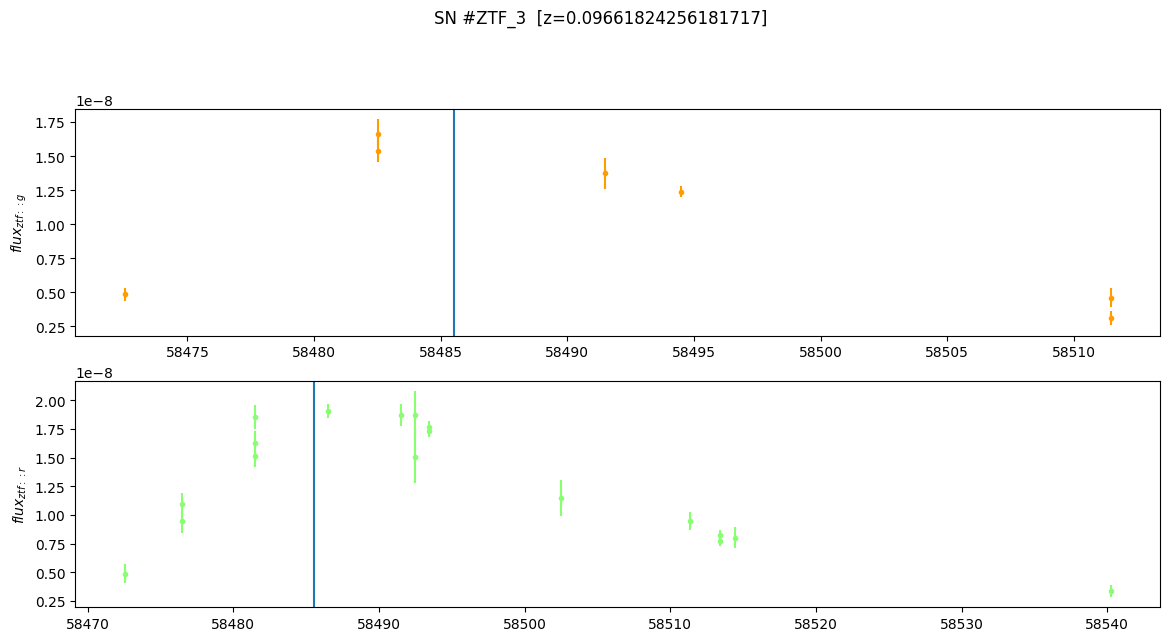

In [95]:
sn = "ZTF_3"
tds.plot_lcs(sn)

### lc fit

In [6]:
source = sncosmo.get_source('salt2', version='2.4', )

model = sncosmo.Model(source=source, effects=[sncosmo.CCM89Dust()], effect_names=['mw'], effect_frames=['obs'])

In [7]:
tds = TrainingDataset.read_parquet("/cfs/data/angi0819/Projet_LPNHE/nacl_cli/1_lcfit/tds.parquet",
                                      filterlib=filterlib)

2025-07-18 14:49:47 WARNING root - bandpass MEGACAM6::g not in filterlib -- retrieving it from sncosmo
2025-07-18 14:49:47 WARNING root - bandpass MEGACAM6::i not in filterlib -- retrieving it from sncosmo
2025-07-18 14:49:47 WARNING root - bandpass MEGACAM6::i2 not in filterlib -- retrieving it from sncosmo
2025-07-18 14:49:47 WARNING root - bandpass MEGACAM6::r not in filterlib -- retrieving it from sncosmo
2025-07-18 14:49:47 WARNING root - bandpass MEGACAM6::z not in filterlib -- retrieving it from sncosmo
2025-07-18 14:49:47 WARNING root - bandpass ztf::i not in filterlib -- retrieving it from sncosmo
2025-07-18 14:49:47 INFO nacl.dataset - indexing light curves
2025-07-18 14:49:48 INFO nacl.dataset - indexing spectra
2025-07-18 14:49:48 WARNING nacl.dataset - _index_spectra: no spectra no index - pass


In [8]:
sn_data = pandas.DataFrame(tds.sn_data.nt).drop(columns='index').set_index('sn', drop=False)
sn_data.index.name=None

In [9]:
lc_data = pandas.DataFrame(tds.lc_data.nt).drop(columns='index').set_index('sn', drop=False).rename(columns=dict(mjd="time", magsys='zpsys'))

In [10]:
lc_data = lc_data[['time', 'band', 'flux', 'fluxerr', 'zp', 'zpsys', 'sn', 'lc']].copy()

In [345]:
def res_to_table(res, sn):
    fitted_values = {**{k:v for k, v in zip(res.param_names, res.parameters) if k in res.vparam_names},
                     **{k+"_err":v for k, v in res.errors.items()},}

    for i in range(len(res.vparam_names)):
        for j in range(i, len(res.vparam_names)):
            fitted_values["cov_" + res.vparam_names[i]+"_"+res.vparam_names[j]]=res.covariance[i,j]

    for k in ['success', 'ncall', 'chisq', 'ndof']:
        fitted_values[k] = res[k]
    return pandas.DataFrame(fitted_values, index=[sn])

def fit_sn(sn, lc_data, z, mwebv, model):
    model.set(z=z, mwebv=mwebv)
    res, fitted_model = sncosmo.fit_lc(lc_data, model,
                                       vparam_names=["x0", "x1", "c", "t0"],
                                       modelcov=True,
                                       bounds={"x0":[-1., 10.],
                                               "x1":[-4., 4.],
                                               "c": [-0.4, 1.]},
                                       phase_range=[-10, 40])
    df = res_to_table(res, sn)
    df['z'] = z
    df['mwebv'] = mwebv
    return df

In [346]:
from astropy.table import Table

def fit_all(sn_data, lc_data, client=None):
    if client is None:
        results = [fit_sn(sn, Table.from_pandas(lc_data.loc[sn]), sn_data.loc[sn,'z'], sn_data.loc[sn,'mwebv'], model) for sn in tqdm(lc_data.index.unique())]
        return pandas.concat(results)
    else:
        future_results = [delayed(fit_sn)(sn, Table.from_pandas(lc_data.loc[sn]), sn_data.loc[sn,'z'], sn_data.loc[sn,'mwebv'], model)
                            for sn in lc_data.index.unique()]
        return future_results

In [347]:
sn = 'HSC_10041'

In [348]:
_data = Table.from_pandas(lc_data.loc[sn])
_z = sn_data.loc[sn, 'z']
_x0 = sn_data.loc[sn, 'x0']
_x1 = sn_data.loc[sn, 'x1']
_c = sn_data.loc[sn, 'c']
_mwebv = sn_data.loc[sn, 'mwebv']
_t0 = sn_data.loc[sn, 'tmax']

In [349]:
_z, _mwebv, _t0

(0.5369499921798706, 0.03022138588130474, 58837.4765625)

In [350]:
model.set(z=_z, mwebv=_mwebv, t0=_t0, x0=_x0, x1=_x1, c=_c)

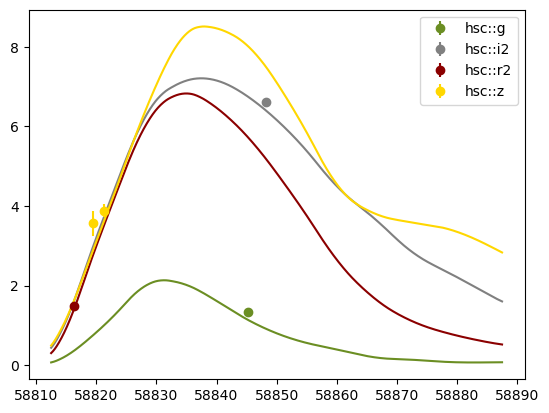

In [351]:
coeff = np.power(10,(-(_data["zp"] - 25) / 2.5))

for b in np.unique(_data['band']):
    filt = (_data['band']==b)
    plt.errorbar(_data['time'][filt],
                 _data['flux'][filt] * coeff[filt],
                 _data['fluxerr'][filt] * coeff[filt],
                 c = color_band[b],
                 linestyle='', marker='o', label=b)
    plt.plot(np.linspace(_t0 - 25, _t0 + 50, 1000),
             model.bandflux(np.array([b]*1000), np.linspace(_t0 - 25, _t0 + 50, 1000), zp=25, zpsys='ab'),
             c = color_band[b],)
plt.legend()

In [352]:
res, fitted_model = sncosmo.fit_lc(_data, model,
                               vparam_names=["x0", "x1", "c", "t0"],
                               bounds={"x0":[-1., 10.],
                                       "x1":[-4., 4.],
                                       "c": [-0.2, 0.8],
                                       "t0": [_t0 - 10, _t0 + 10]},
                                phase_range=[-10, 40],
                                verbose=True,
                               )
res_to_table(res, sn)

Initial parameters:
t0 58847.82298569145 step= 0.4 bounds= [58827.4765625, 58847.4765625] 
x0 7.692109033750384e-06 step= 0.22 bounds= [-1.0, 10.0] 
x1 1.4700000286102295 step= 0.16 bounds= [-4.0, 4.0] 
c 0.06800000369548798 step= 0.02 bounds= [-0.2, 0.8] 

155 function calls; 1 dof.
Initial parameters:
t0 58838.27106280761 step= 0.4 bounds= [58827.4765625, 58847.4765625] 
x0 8.378074607410927e-06 step= 0.22 bounds= [-1.0, 10.0] 
x1 2.570306548206029 step= 0.16 bounds= [-4.0, 4.0] 
c 0.06614934229222647 step= 0.02 bounds= [-0.2, 0.8] 

54 function calls; -2 dof.


,t0,x0,x1,c,t0_err,x0_err,x1_err,c_err,cov_t0_t0,cov_t0_x0,...,cov_x0_x0,cov_x0_x1,cov_x0_c,cov_x1_x1,cov_x1_c,cov_c_c,success,ncall,chisq,ndof
HSC_10041,58838.272977,0.000008,2.571778,0.066154,2.86678,0.000001,1.981913,0.082209,8.455568,-0.000003,...,1.245066e-12,-0.000002,-9.156307e-08,4.645599,0.172071,0.006838,True,54,0.000022,-2


In [353]:
fit_sn(sn, lc_data.loc[sn].to_dict(orient='list'), sn_data.loc[sn, 'z'], sn_data.loc[sn, 'mwebv'], model)

,t0,x0,x1,c,t0_err,x0_err,x1_err,c_err,cov_t0_t0,cov_t0_x0,...,cov_x0_c,cov_x1_x1,cov_x1_c,cov_c_c,success,ncall,chisq,ndof,z,mwebv
HSC_10041,58838.273803,0.000008,2.570862,0.066164,9.513957,0.000003,7.261017,0.27422,91.202531,-0.000032,...,-9.795759e-07,55.234138,2.010154,0.079976,True,54,2.723038e-07,-2,0.53695,0.030221


In [354]:
try:
    client.close()
except:
    pass

In [355]:
from dask.distributed import Client, get_client
Client(n_workers=16, threads_per_worker=4)
client=get_client()

2025-07-18 16:28:25 INFO distributed.scheduler - State start
2025-07-18 16:28:25 INFO distributed.scheduler -   Scheduler at:     tcp://127.0.0.1:36447
2025-07-18 16:28:25 INFO distributed.scheduler -   dashboard at:  http://127.0.0.1:8787/status
2025-07-18 16:28:25 INFO distributed.scheduler - Registering Worker plugin shuffle
2025-07-18 16:28:25 INFO distributed.nanny -         Start Nanny at: 'tcp://127.0.0.1:37584'
2025-07-18 16:28:25 INFO distributed.nanny -         Start Nanny at: 'tcp://127.0.0.1:35557'
2025-07-18 16:28:25 INFO distributed.nanny -         Start Nanny at: 'tcp://127.0.0.1:38703'
2025-07-18 16:28:25 INFO distributed.nanny -         Start Nanny at: 'tcp://127.0.0.1:37254'
2025-07-18 16:28:25 INFO distributed.nanny -         Start Nanny at: 'tcp://127.0.0.1:34312'
2025-07-18 16:28:25 INFO distributed.nanny -         Start Nanny at: 'tcp://127.0.0.1:37137'
2025-07-18 16:28:25 INFO distributed.nanny -         Start Nanny at: 'tcp://127.0.0.1:46461'
2025-07-18 16:28:25

In [356]:
from dask.delayed import delayed
submit_results = [delayed(fit_sn)(sn, Table.from_pandas(lc_data.loc[sn]), sn_data.loc[sn,'z'], sn_data.loc[sn,'mwebv'], model)
                    for sn in tqdm(lc_data.index.unique(), desc='Creating delayed objects')]

Creating delayed objects:   0%|          | 0/5903 [00:00<?, ?it/s]

In [357]:
from dask.distributed import progress
futures_results = client.compute(submit_results)
progress(futures_results)

2025-07-18 16:28:48 WARNING py.warnings - /cfs/home/angi0819/conda/envs/lemaitre/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 66.71 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(



VBox()

2025-07-18 16:34:18,506 - distributed.worker - ERROR - Compute Failed
Key:       fit_sn-9f787b0b-9559-48d9-b6d3-51b2cce7294e
State:     executing
Task:  <Task 'fit_sn-9f787b0b-9559-48d9-b6d3-51b2cce7294e' fit_sn(...)>
Exception: 'TypeError("\'NoneType\' object is not subscriptable")'
Traceback: '  File "/tmp/ipykernel_3092/219009771.py", line 22, in fit_sn\n  File "/tmp/ipykernel_3092/219009771.py", line 7, in res_to_table\n'



In [359]:
res_ = client.gather(futures_results, errors='skip')

In [360]:
res = pandas.concat(res_)

In [537]:
res["survey"] = list(map(lambda x: x.split("_")[0], np.array(res.index)))

In [361]:
chi2_cut = (res.chisq/res.ndof < 3) & (res.ndof > 0)
x1_cut = res.x1.between(-3, 3)
c_cut = res.c.between(-0.2, 0.8)
sigma_t0 = (res.t0_err < 1)
sigma_x1 = (res.x1_err < 1)
sigma_c = (res.c_err < 1)

In [586]:
total_cut = res.t0 > 0
print(f"\t\tSNe kept\tCut")
print(f"Total\t\t{total_cut.sum()}\t\t-")

for cut in ["chi2_cut", "x1_cut", "c_cut", "sigma_t0", "sigma_x1", "sigma_c"]:
    print(cut+f"   \t{(total_cut & eval(cut)).sum()}\t\t{total_cut.sum()-(total_cut & eval(cut)).sum()}")
    total_cut &= eval(cut)
print("-"*36)
print(f"Total\t\t{total_cut.sum()}\t\t{(~total_cut).sum()}")
res.loc[~total_cut, "success"] = False    

		SNe kept	Cut
Total		5902		-
chi2_cut   	5875		27
x1_cut   	5842		33
c_cut   	5826		16
sigma_t0   	5589		237
sigma_x1   	5474		115
sigma_c   	5474		0
------------------------------------
Total		5474		428


In [571]:
print('\tTotal\tGoods')
for s in res.survey.unique():
    print(s +f"\t{(res.survey==s).sum()}\t{(res.success & (res.survey==s)).sum()}")

	Total	Goods
HSC	112	37
SNLS	531	341
ZTF	5259	5096


In [471]:
model.set(z=0, x0=1, c=0, x1=0, t0=0, mwebv=0)
model.bandmag('bessellb', 'ab', 0.)

10.505605130259038

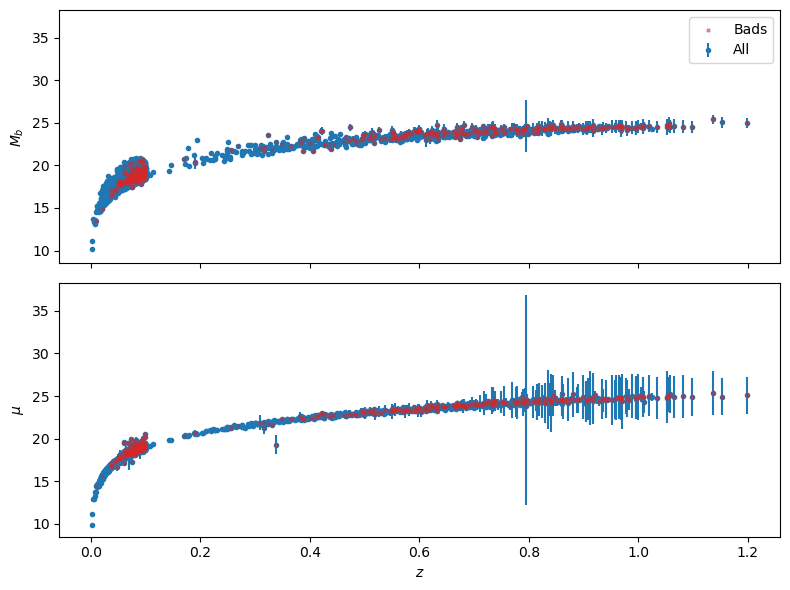

In [601]:
fig, (axmb, axmu) = plt.subplots(nrows=2, sharey=True, sharex=True, figsize=(8,6))
axmb.errorbar(res.z,
             res.Mb + model.bandmag('bessellb', 'ab', 0.),
             res.Mb_err,
            marker='.',
            linestyle='', label='All')
axmb.scatter(res[~res.success].z,
             res[~res.success].Mb + model.bandmag('bessellb', 'ab', 0.),
             s=5,
             alpha=0.6,
             marker='x',
            color='tab:red', zorder=10, label='Bads')
axmb.legend()
axmb.set_ylabel("$M_b$")
axmu.errorbar(res.z,
             res.mu + model.bandmag('bessellb', 'ab', 0.),
             res.mu_err,
            marker='.',
            linestyle='', label=r'$\mu$')
axmu.scatter(res[~res.success].z,
             res[~res.success].mu + model.bandmag('bessellb', 'ab', 0.),
             s=5,
             alpha=0.6,
             marker='x',
            color='tab:red', zorder=10)

axmu.set_xlabel("$z$")
axmu.set_ylabel(r"$\mu$")
fig.tight_layout()

In [371]:
def build_cov_from_df(res):
    cov = np.zeros((3,3, len(res)))
    for i, k1 in enumerate(['x0', 'x1', 'c']):
        for j, k2 in enumerate(['x0', 'x1', 'c']):
            if i <= j:
                cov[i,j,...] = cov[j,i,...] = res['cov_' + k1 + '_' + k2]
    return cov.T

In [379]:
covs = build_cov_from_df(res)

In [380]:
test = (np.identity(3)[..., None] @ np.ones(len(res))[None, None,...])
test[0, 0] =  -2.5 / (np.log(10) * res["x0"].values)
test=test.T

In [383]:
new_covs=np.matmul(test, np.matmul(covs, test))

In [385]:
res['Mb_err']=np.sqrt(new_covs[...,0,0])
res['Mb'] = -2.5*np.log10(res['x0'])

In [524]:
res['mu'] = res.Mb + 0.14*res.x1 - 3.15*res.c
to_mu = (np.array([[1, 0.14, -3.15]])[..., None] @ np.ones(len(res))[None, None,...]).T

In [525]:
res['mu_err'] = np.sqrt(np.matmul(to_mu.transpose((0, 2, 1)), np.matmul(new_covs, to_mu)).reshape(-1))

2025-07-18 17:48:51 INFO matplotlib.mathtext - Substituting symbol N from STIXNonUnicode
2025-07-18 17:48:51 INFO matplotlib.mathtext - Substituting symbol ( from STIXGeneral
2025-07-18 17:48:51 INFO matplotlib.mathtext - Substituting symbol 0 from STIXGeneral
2025-07-18 17:48:51 INFO matplotlib.mathtext - Substituting symbol , from STIXGeneral
2025-07-18 17:48:51 INFO matplotlib.mathtext - Substituting symbol . from STIXGeneral
2025-07-18 17:48:51 INFO matplotlib.mathtext - Substituting symbol 1 from STIXGeneral
2025-07-18 17:48:51 INFO matplotlib.mathtext - Substituting symbol 5 from STIXGeneral
2025-07-18 17:48:51 INFO matplotlib.mathtext - Substituting symbol ) from STIXGeneral
2025-07-18 17:48:51 INFO matplotlib.mathtext - Substituting symbol N from STIXNonUnicode
2025-07-18 17:48:51 INFO matplotlib.mathtext - Substituting symbol ( from STIXGeneral
2025-07-18 17:48:51 INFO matplotlib.mathtext - Substituting symbol 0 from STIXGeneral
2025-07-18 17:48:51 INFO matplotlib.mathtext - S

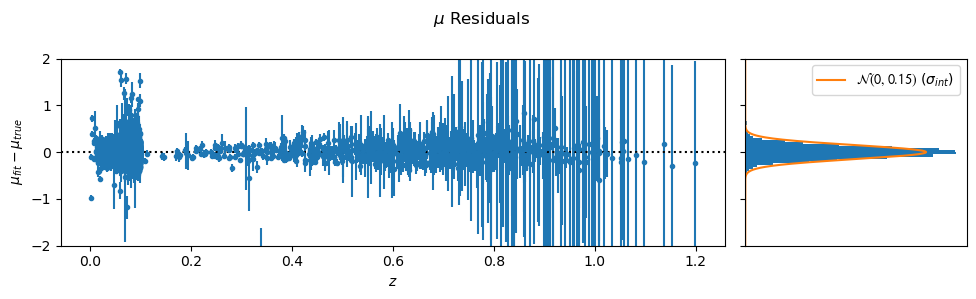

In [547]:
fig, axs = plt.subplots(figsize=(10, 3), width_ratios=[3, 1], ncols=2, sharey='row')
axs[0].errorbar(res.z,
             res.mu + model.bandmag('bessellb', 'ab', 0.) + 19.3 - cosmo.distmod(res.z).value,
             res.mu_err,
            marker='.',
            linestyle='')
axs[0].axhline(0, linestyle=':', color='k')
axs[1].hist((res.mu + model.bandmag('bessellb', 'ab', 0.) + 19.3 - \
          cosmo.distmod(res.z).value),
            orientation='horizontal',
            density=True,
            bins=100,)

axs[1].plot(1/np.sqrt(2*np.pi)/0.15*np.exp(-(np.linspace(-2, 2, 1000)/0.15)**2/2), np.linspace(-2, 2, 1000), label=r'$\mathcal{N(0, 0.15)}$ ($\sigma_{int}$)')
axs[1].legend()

axs[0].set_ylim(-2, 2)
axs[0].set_ylabel(r'$\mu_{fit} - \mu_{true}$')
axs[0].set_xlabel(r'$z$')
axs[1].set_xticks([])
fig.suptitle(r"$\mu$ Residuals")
fig.tight_layout()

2025-07-18 17:48:41 INFO matplotlib.mathtext - Substituting symbol N from STIXNonUnicode
2025-07-18 17:48:41 INFO matplotlib.mathtext - Substituting symbol ( from STIXGeneral
2025-07-18 17:48:41 INFO matplotlib.mathtext - Substituting symbol 0 from STIXGeneral
2025-07-18 17:48:41 INFO matplotlib.mathtext - Substituting symbol , from STIXGeneral
2025-07-18 17:48:41 INFO matplotlib.mathtext - Substituting symbol 1 from STIXGeneral
2025-07-18 17:48:41 INFO matplotlib.mathtext - Substituting symbol ) from STIXGeneral
2025-07-18 17:48:41 INFO matplotlib.mathtext - Substituting symbol N from STIXNonUnicode
2025-07-18 17:48:41 INFO matplotlib.mathtext - Substituting symbol ( from STIXGeneral
2025-07-18 17:48:41 INFO matplotlib.mathtext - Substituting symbol 0 from STIXGeneral
2025-07-18 17:48:41 INFO matplotlib.mathtext - Substituting symbol , from STIXGeneral
2025-07-18 17:48:41 INFO matplotlib.mathtext - Substituting symbol 1 from STIXGeneral
2025-07-18 17:48:41 INFO matplotlib.mathtext - S

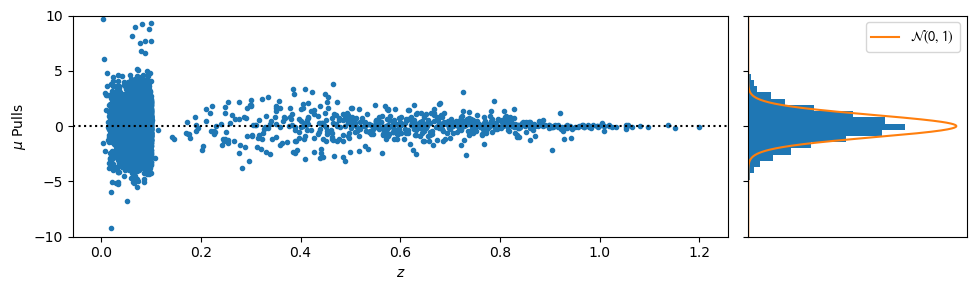

In [546]:
fig, axs = plt.subplots(figsize=(10, 3), width_ratios=[3, 1], ncols=2, sharey='row')
axs[0].scatter(res.z,
         (res.mu + model.bandmag('bessellb', 'ab', 0.) + 19.3 - \
          cosmo.distmod(res.z).value)/res.mu_err,
        marker='.')
axs[0].axhline(0, linestyle=':', color='k')
axs[1].hist((res.mu + model.bandmag('bessellb', 'ab', 0.) + 19.3 - \
          cosmo.distmod(res.z).value)/res.mu_err,
            orientation='horizontal',
            density=True,
            bins=100,)
axs[1].plot(1/np.sqrt(2*np.pi)*np.exp(-np.linspace(-10, 10, 1000)**2/2), np.linspace(-10, 10, 1000), label=r'$\mathcal{N(0, 1)}$')
axs[1].legend()
axs[0].set_ylim(-10, 10)
axs[0].set_ylabel(r'$\mu$ Pulls')
axs[0].set_xlabel(r'$z$')
axs[1].set_xticks([])
fig.tight_layout()

In [100]:
res['t0_true'] = sn_data.tmax
res['x0_true'] = sn_data.x0
res['x1_true'] = sn_data.x1
res['c_true'] = sn_data.c

In [113]:
import copy
true_model = copy.copy(model)
true_model.set(**{k if k!='tmax' else 't0':sn_data.loc[sn, k] for k in ['tmax', 'x0', 'x1', 'c']})

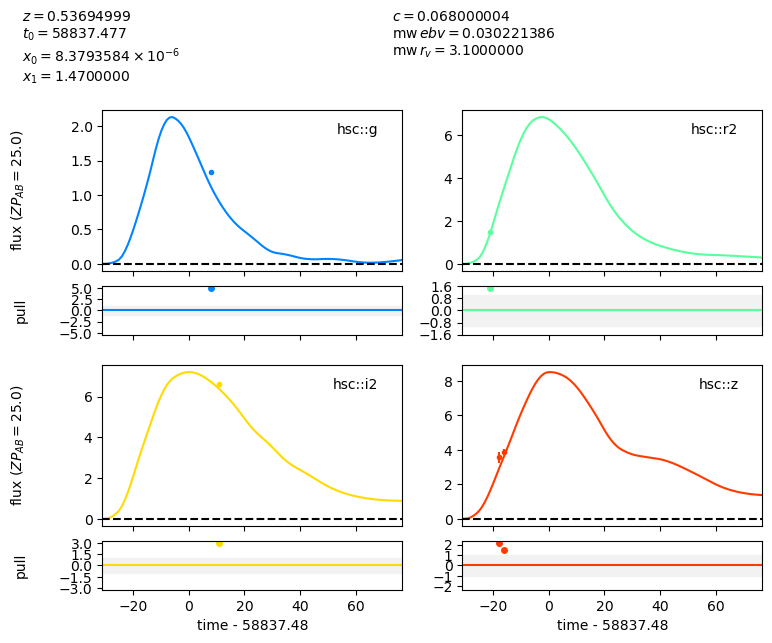

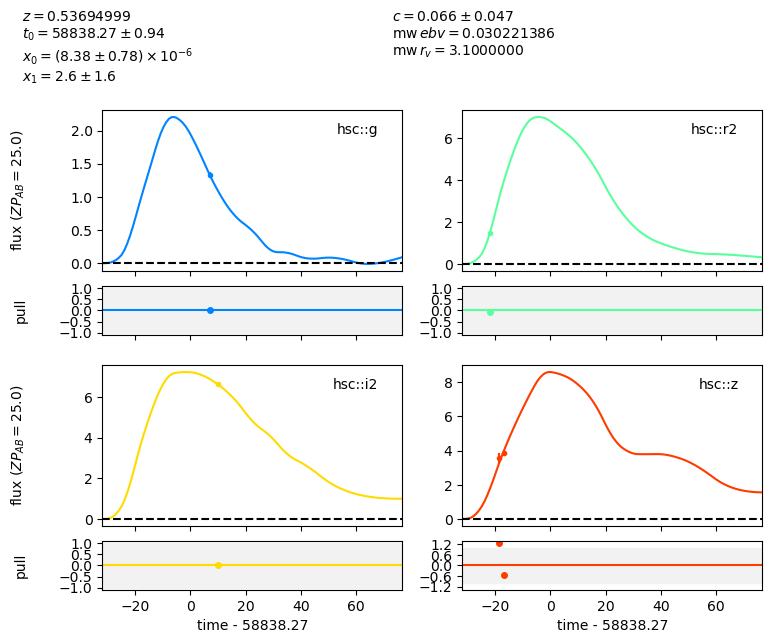

In [119]:
_=sncosmo.plot_lc(_data, true_model)
_=sncosmo.plot_lc(_data, fitted_model, errors=res.errors)

In [7]:
sn_pars = pandas.read_parquet("/cfs/data/angi0819/Projet_LPNHE/nacl_cli/1_lcfit/nacl_sn_pars.parquet")

In [8]:
cov = np.load("/cfs/data/angi0819/Projet_LPNHE/nacl_cli/1_lcfit/nacl_sn_pars_cov.npy")

In [9]:
errs_ = np.sqrt(np.diag(cov))
sn_pars["x0_err"] = errs_[:len(sn_pars)]
sn_pars["x1_err"] = errs_[len(sn_pars):2*len(sn_pars)]
sn_pars["c_err"] = errs_[2*len(sn_pars):3*len(sn_pars)]
sn_pars["tmax_err"] = errs_[3*len(sn_pars):]


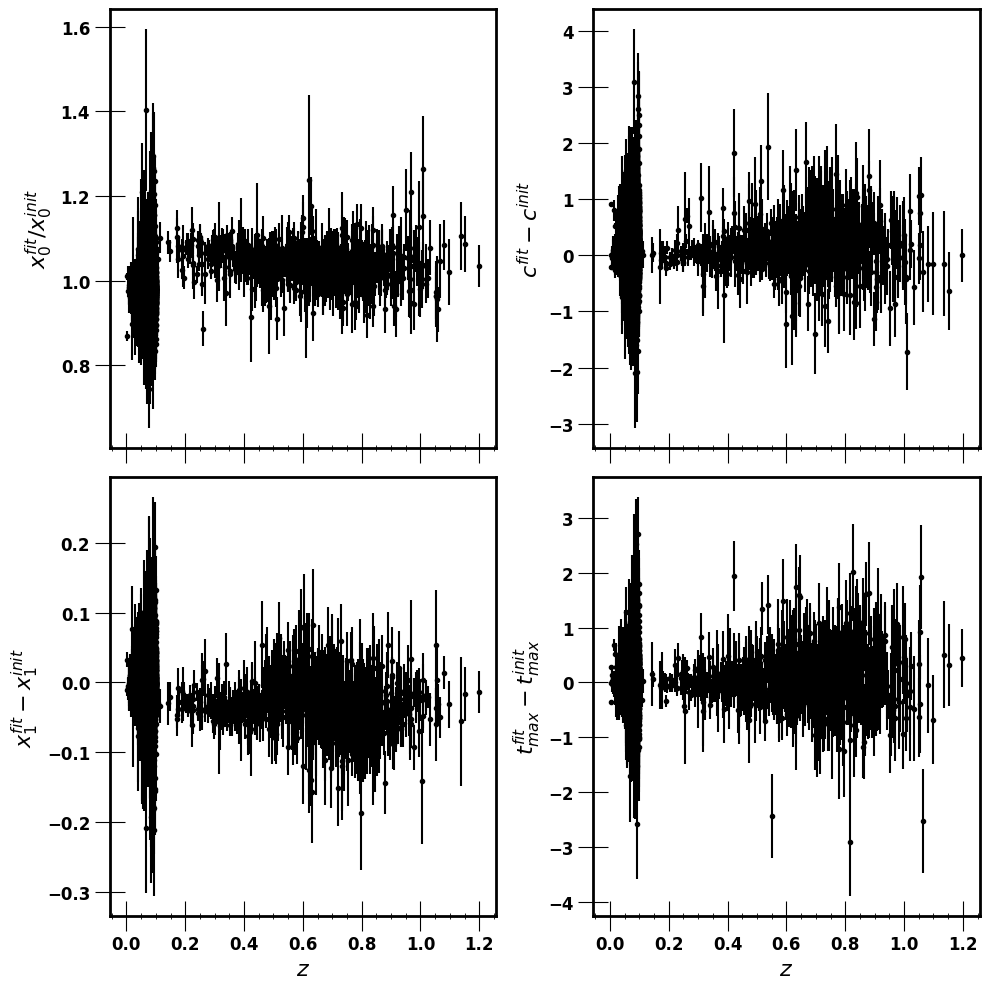

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10), sharex='all')
sty = dict(marker='.', linestyle='', color='k')
axs[0, 0].errorbar(sn_pars.z,
                   sn_pars.x0/sn_pars.x0_init,
                   sn_pars.x0_err/sn_pars.x0_init,
                   **sty)
axs[0, 1].errorbar(sn_pars.z,
                   sn_pars.x1-sn_pars.x1_init,
                   sn_pars.x1_err,
                   **sty)
axs[1, 0].errorbar(sn_pars.z,
                   sn_pars.c-sn_pars.c_init,
                   sn_pars.c_err,
                   **sty)
axs[1, 1].errorbar(sn_pars.z,
                   sn_pars.tmax-sn_pars.tmax_init,
                   sn_pars.tmax_err,
                   **sty)
axs[1, 1].set_xlabel('$z$')
axs[1, 0].set_xlabel('$z$')
axs[0, 0].set_ylabel(r'$x_0^{fit}/x_0^{init}$')
axs[1, 0].set_ylabel(r'$x_1^{fit}-x_1^{init}$')
axs[0, 1].set_ylabel(r'$c^{fit}-c^{init}$')
axs[1, 1].set_ylabel(r'$t_{max}^{fit}-t_{max}^{init}$')
fig.tight_layout()

Text(0, 0.5, 'Pulls $t_{max}$')

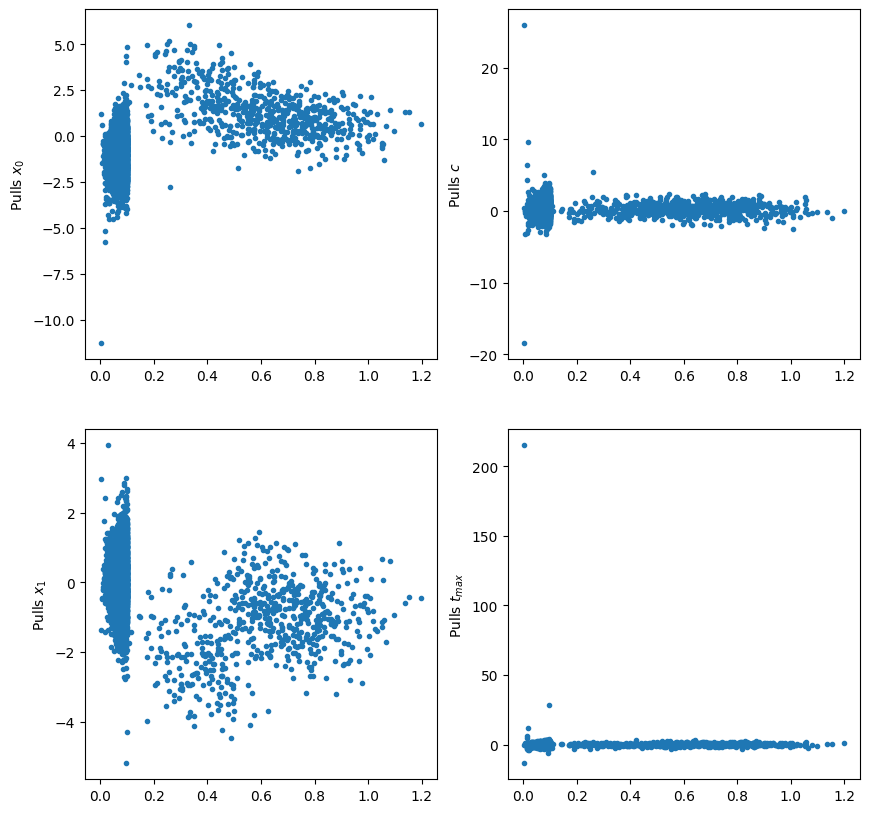

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
sty = dict(marker='.',)
axs[0, 0].scatter(sn_pars.z,
                   (sn_pars.x0 - sn_pars.x0_init)/sn_pars.x0_err,
                   **sty)
axs[0, 1].scatter(sn_pars.z,
                   (sn_pars.x1-sn_pars.x1_init)/sn_pars.x1_err,
                   **sty)
axs[1, 0].scatter(sn_pars.z,
                   (sn_pars.c-sn_pars.c_init)/sn_pars.c_err,
                   **sty)
axs[1, 1].scatter(sn_pars.z,
                   (sn_pars.tmax-sn_pars.tmax_init)/sn_pars.tmax_err,
                   **sty)

axs[0, 0].set_ylabel(r'Pulls $x_0$')
axs[1, 0].set_ylabel(r'Pulls $x_1$')
axs[0, 1].set_ylabel(r'Pulls $c$')
axs[1, 1].set_ylabel(r'Pulls $t_{max}$')


In [12]:
from nacl.io.pickle import load_pickle

In [16]:
fit = load_pickle('/cfs/data/angi0819/Projet_LPNHE/nacl_cli/1_lcfit/distillate.pkl.zst')

2025-07-08 15:42:19 WARNING py.warnings - /cfs/home/angi0819/Projet-LPNHE/sn-nacl/nacl/plotting/snpars.py:220: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])



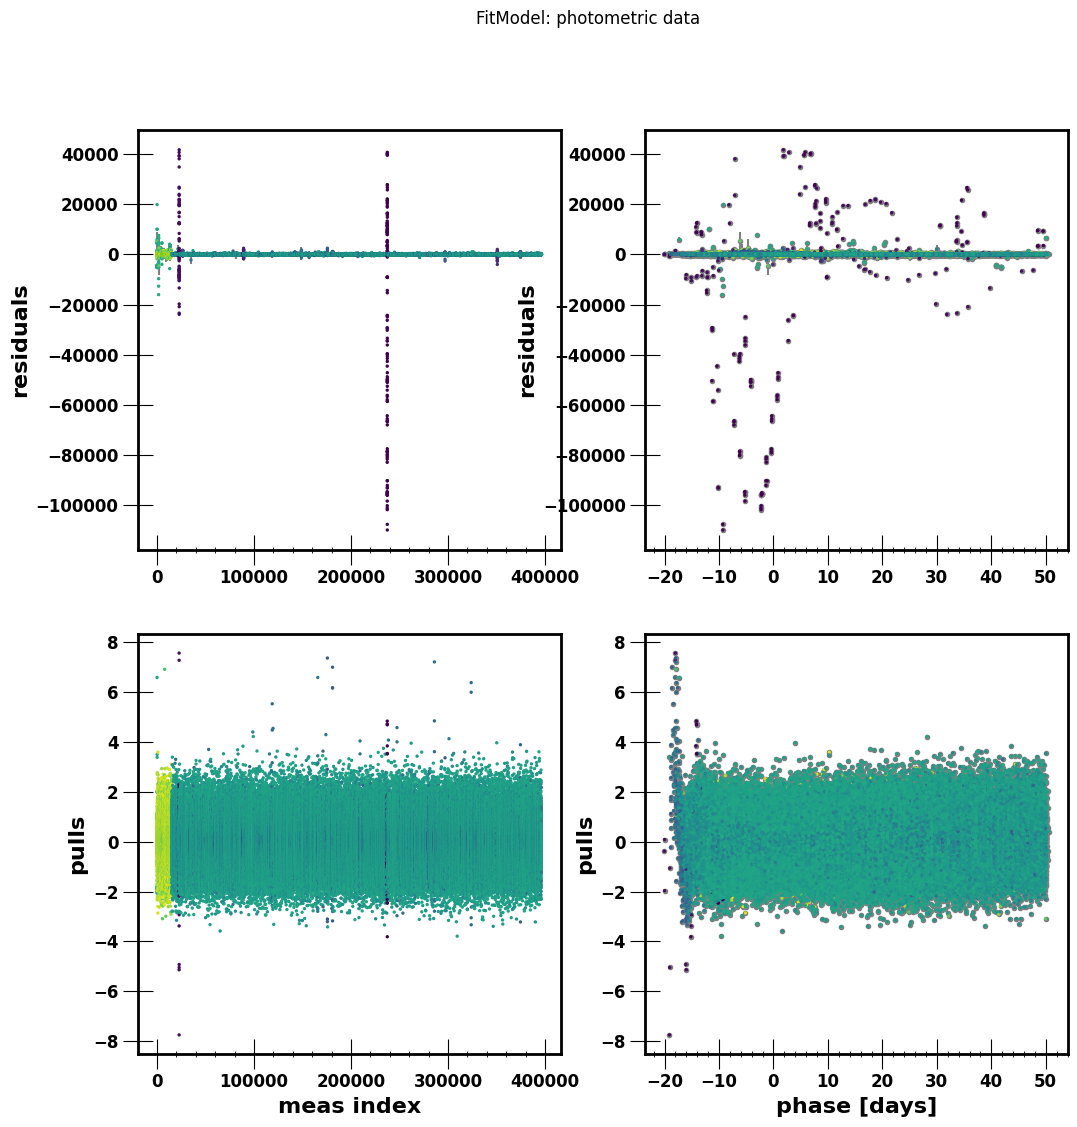

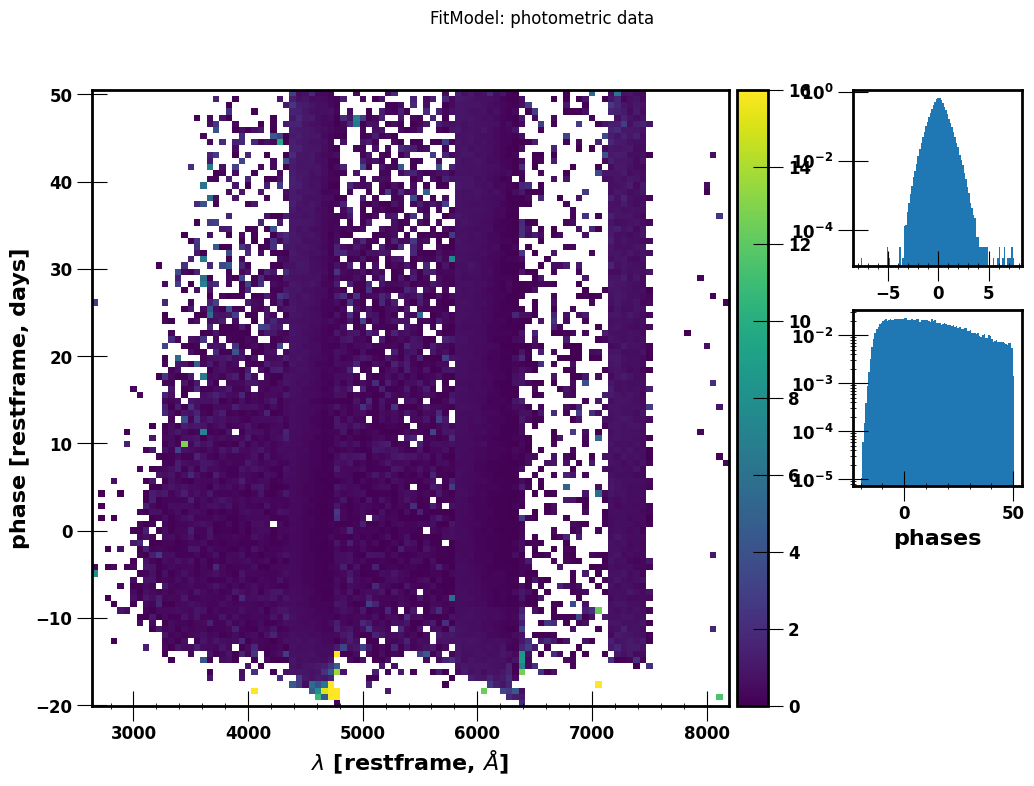

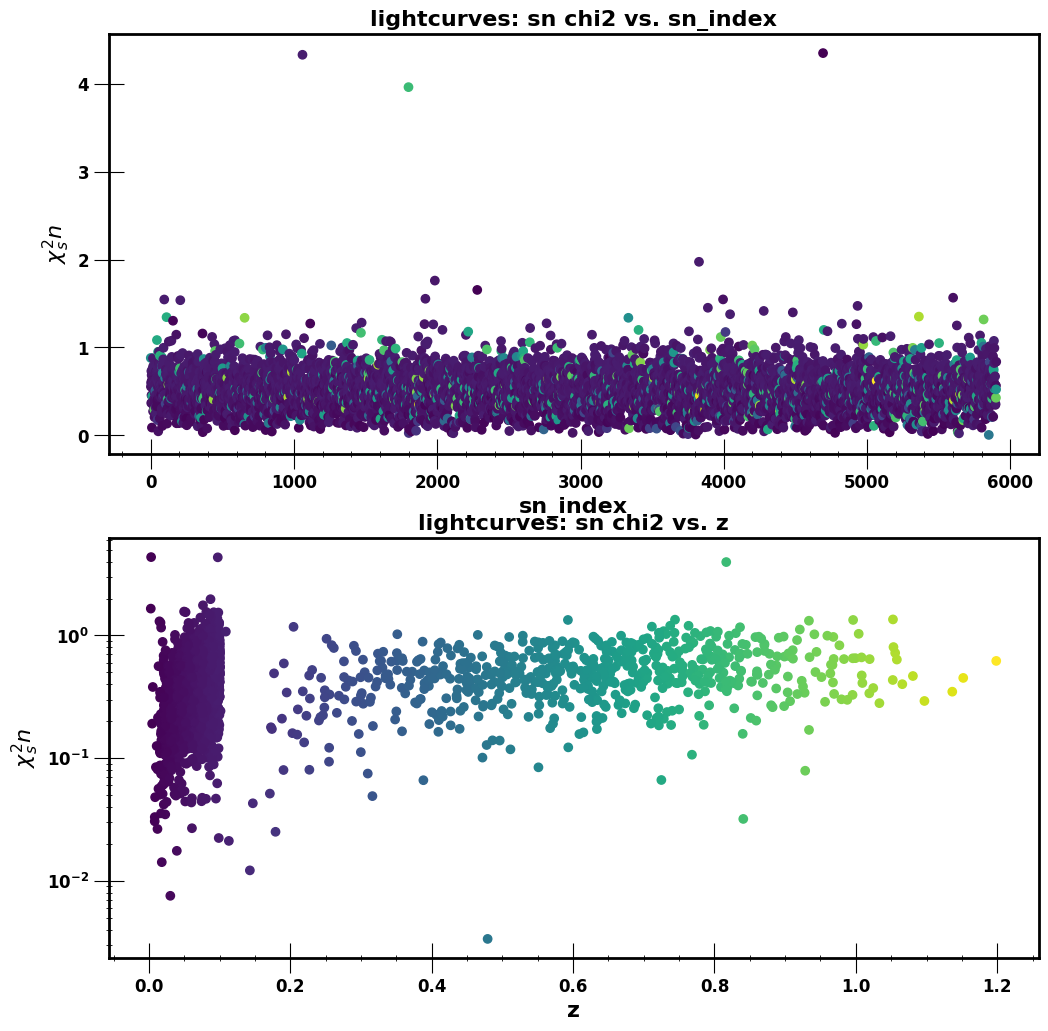

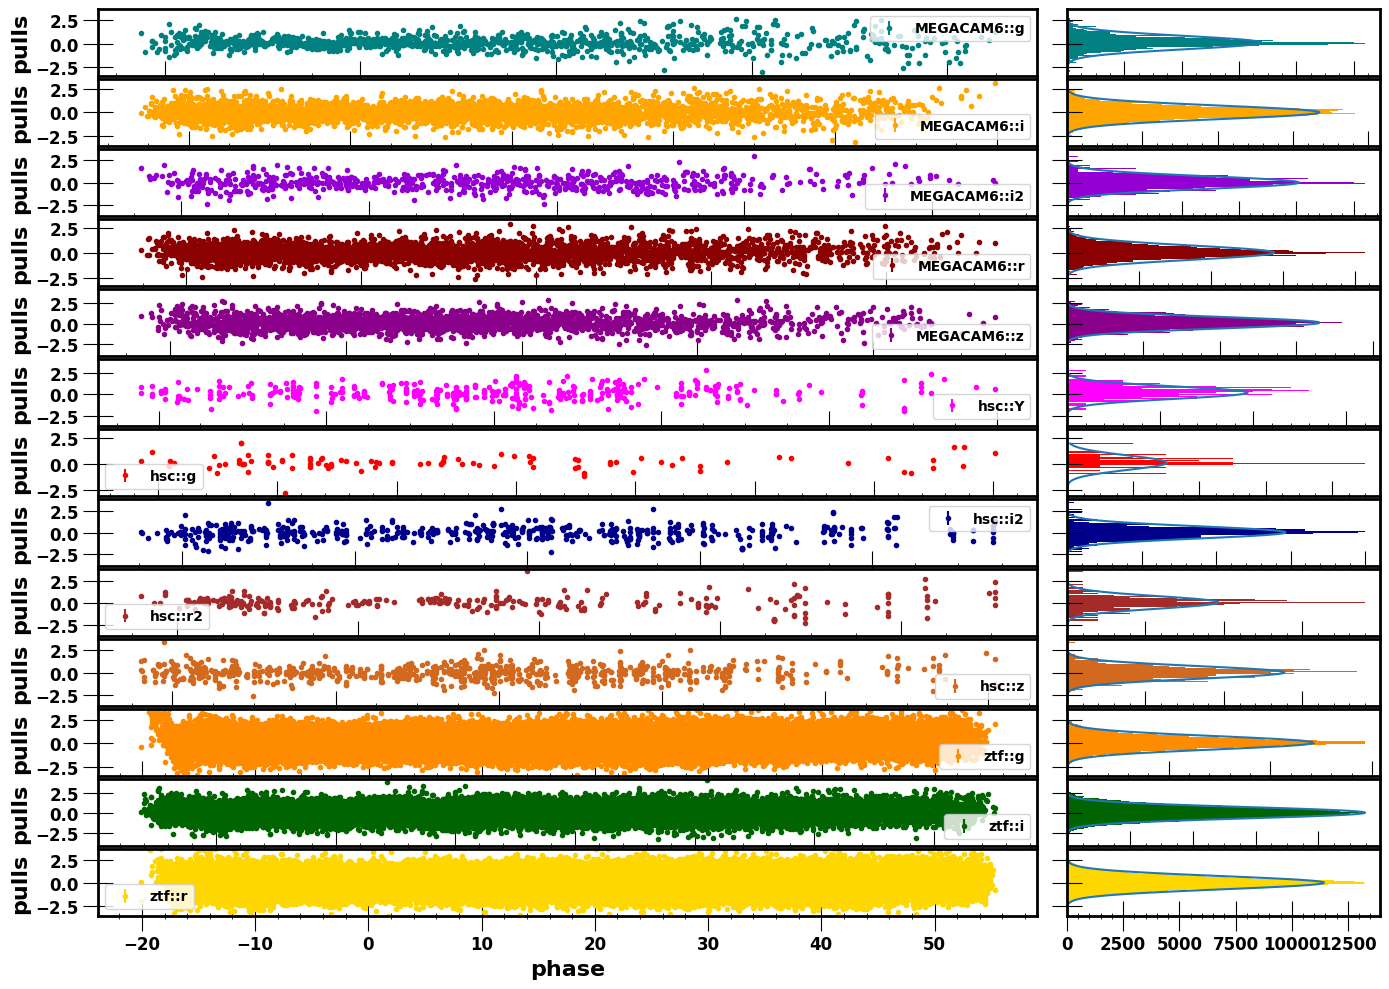

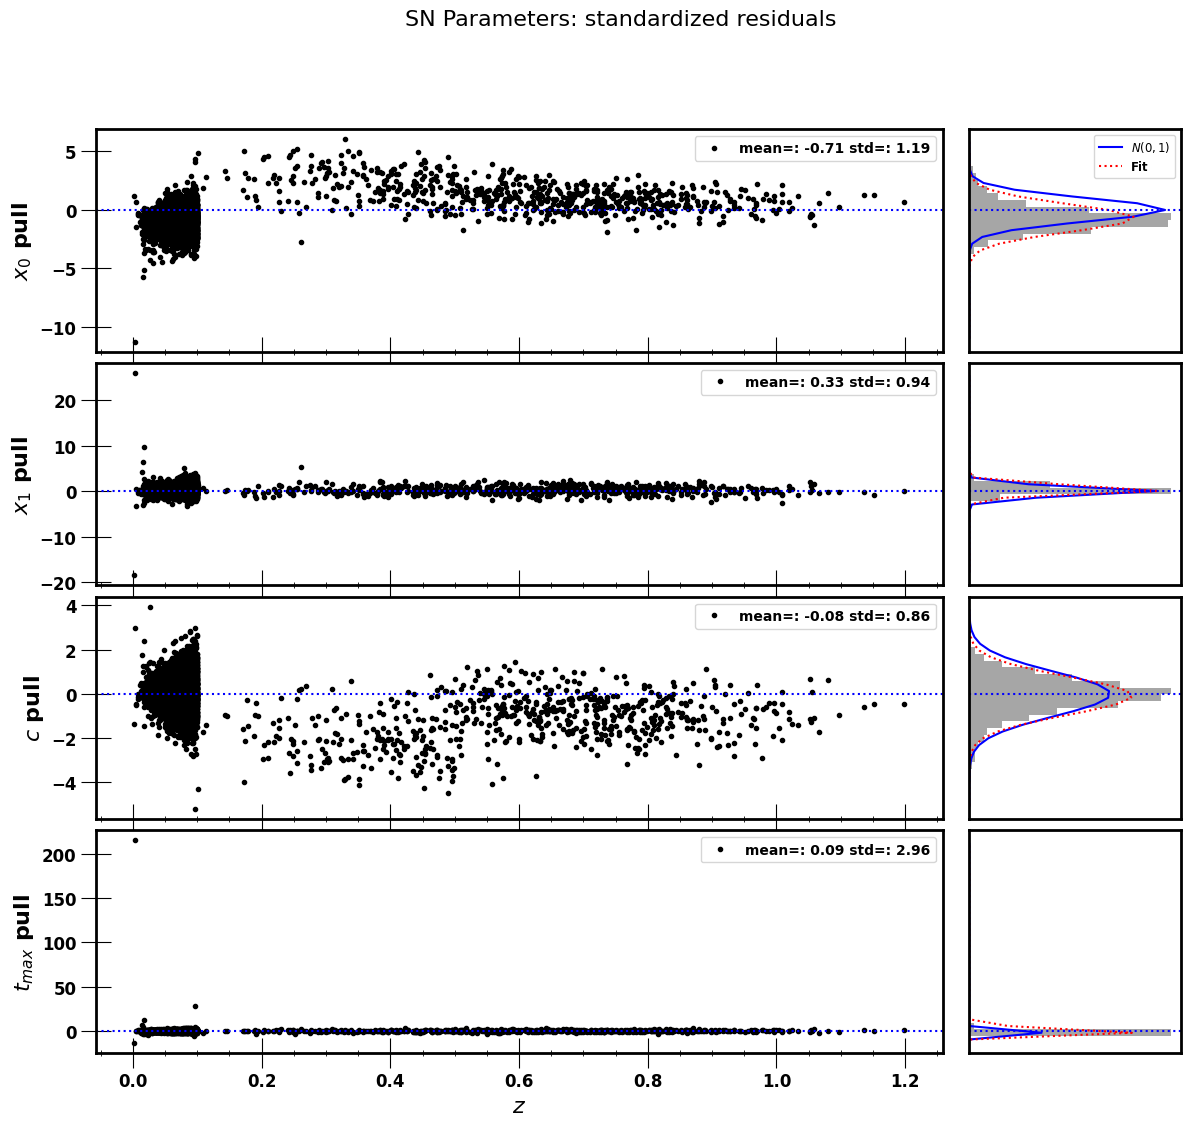

In [24]:
fit.plot(output_dir='/cfs/data/angi0819/Projet_LPNHE/nacl_cli/1_lcfit/')

### Edris

In [ ]:
from edris.georgesutils import CosmoFitter

In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
fitter = CosmoFitter(
    '/cfs/data/angi0819/Projet_LPNHE/test/1_lcfit/' + "output_params.parquet",
    '/cfs/data/angi0819/Projet_LPNHE/test/1_lcfit/' + "output_cov.npy",
    niter=1000,
    lmbda=1e4,
    tol=1e-2,
    max_iter_tncg=None,
    n_bins=21,
    verbose=True,  # TODO make edris use standard logging
    output_save_path='/cfs/data/angi0819/Projet_LPNHE/test/')


In [ ]:
from lemaitre.georges.distance_comparison import compare_mu
compare_mu('/cfs/data/angi0819/Projet_LPNHE/test/1_lcfit/output_params.parquet', '/cfs/data/angi0819/Projet_LPNHE/test/1_lcfit/output_cov.npy',
           '/cfs/data/angi0819/Projet_LPNHE/test/flcdm_edris_output.pkl', true_alpha=0.14, true_beta=3.15,
           edris_cuts_index=(df.cut == 'is_ok').values,savefig_path='/cfs/data/angi0819/Projet_LPNHE/test/')


In [30]:
with open('/cfs/data/angi0819/Projet_LPNHE/test/flcdm_edris_output.pkl', 'rb') as fin:
    edris_res = pickle.loads(fin.read())


In [31]:
edris_res.keys()

dict_keys(['res', 'res_cov', 'loss', 'lambda', 'iter_params'])

In [37]:
df= pandas.read_csv('/cfs/data/angi0819/Projet_LPNHE/test/quality_cuts_edris.dat', delimiter=r'\s+', skiprows=2).rename(columns={'#end':'cut'})

In [8]:
nacl_fit = pandas.read_parquet('/cfs/data/angi0819/Projet_LPNHE/test/1_lcfit/output_params.parquet')

In [9]:
data, lc = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_2M++.pkl", survey="ZTF")

In [10]:
source = sncosmo.get_source('salt2', version='2.4')

In [11]:
model = sncosmo.Model(source)

In [12]:
snia = skysurvey.SNeIa()

In [39]:
nacl_fit.set_index('sn', inplace=True, drop=False)

In [40]:
nacl_fit["valid"] = (df['cut']=='is_ok')

In [41]:
nacl_fit['mu'] = -2.5*np.log10(nacl_fit.x0) - edris_res['res']['coef'][0]*nacl_fit.x1 - edris_res['res']['coef'][1]*nacl_fit.c

In [42]:
nacl_fit['mu_init'] = -2.5*np.log10(nacl_fit.x0_init) + 0.14*nacl_fit.x1_init - 3.15*nacl_fit.c_init

In [43]:
nacl_fit.loc[nacl_fit.valid, 'mu'] = -2.5*np.log10(nacl_fit[nacl_fit.valid].x0) - edris_res['res']['coef'] @ edris_res['res']['variables']

In [32]:
n = {k1:edris_res['res_cov'][k1][k1].shape[1] for k1 in edris_res['res_cov'].keys()}
cov = jnp.vstack([np.hstack([edris_res['res_cov'][k1][k2].reshape(n[k1], n[k2]) for k2 in edris_res['res_cov'].keys()]) for k1 in edris_res['res_cov'].keys()])

In [33]:
x0 = dict(M0=-(19.3 + source.peakmag(band="bessellb", magsys="ab")),
          Omega_m=cosmo.Om0,
          coef=jnp.array([-0.14, 3.15]),
          sigma_int=jnp.array([0.1]))

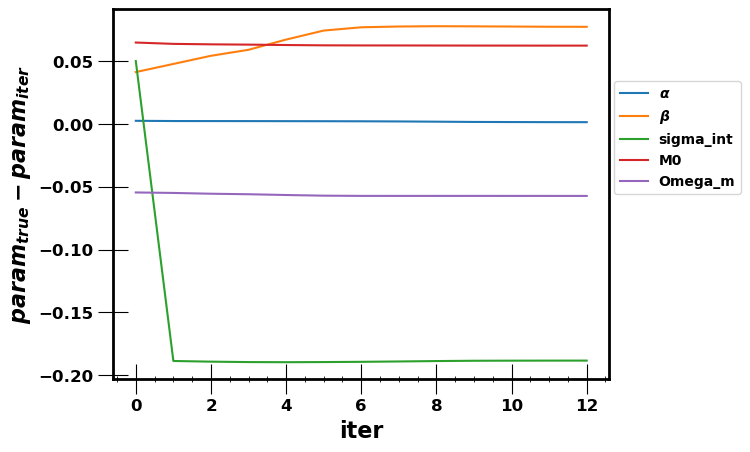

In [34]:
%matplotlib inline
for key in ["coef", 'sigma_int' , "M0", "Omega_m"]:
    plt.plot([iter_p[key]-x0[key] for iter_p in edris_res['iter_params']], label=[r'$\alpha$', r'$\beta$'] if key=='coef' else key)

plt.ylabel(r"$param_{true} - param_{iter}$")
plt.xlabel("iter")
plt.legend(loc=(1.01, 0.5))


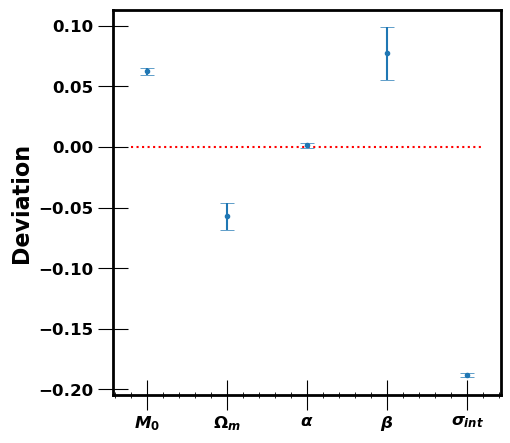

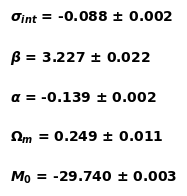

In [36]:
plot_edris_biais(edris_res['res'], x0, cov)

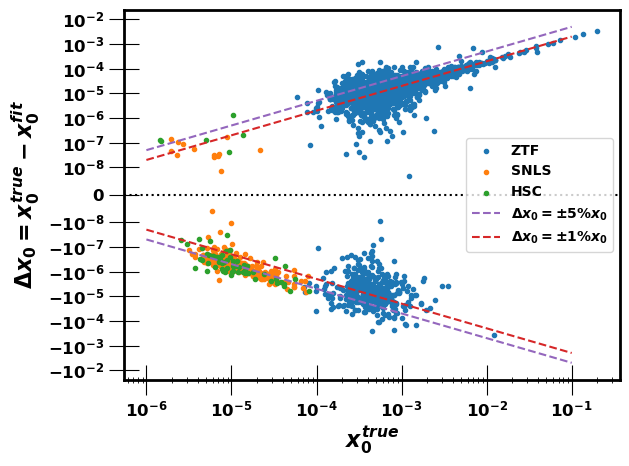

In [16]:
for s in nacl_fit.survey.unique():
    plt.scatter(nacl_fit[nacl_fit.survey==s].x0_init,
                nacl_fit[nacl_fit.survey==s].x0_init - nacl_fit[nacl_fit.survey==s].x0,
                marker='.', color=survey_colors[s], label=s)
plt.axhline(0, linestyle=':', color='k')
plt.plot([1e-6, 1e-1], 0.05*np.array([1e-6, 1e-1]), linestyle='--', color='tab:purple', label=r"$\Delta x_0 = \pm 5\% x_0$")
plt.plot([1e-6, 1e-1], -0.05*np.array([1e-6, 1e-1]), linestyle='--', color='tab:purple')
plt.plot([1e-6, 1e-1], 0.02*np.array([1e-6, 1e-1]), linestyle='--', color='tab:red', label=r"$\Delta x_0 = \pm 1\% x_0$")
plt.plot([1e-6, 1e-1], -0.02*np.array([1e-6, 1e-1]), linestyle='--', color='tab:red')
plt.yscale('symlog', linthresh=1e-8)
plt.xscale('log')
plt.xlabel(r'$x_0^{true}$')
plt.legend()
plt.ylabel(r'$\Delta x_0 = x_0^{true} - x_0^{fit}$')
plt.savefig('/cfs/data/angi0819/Projet_LPNHE/figures/nacl_lcfit/x0.png')

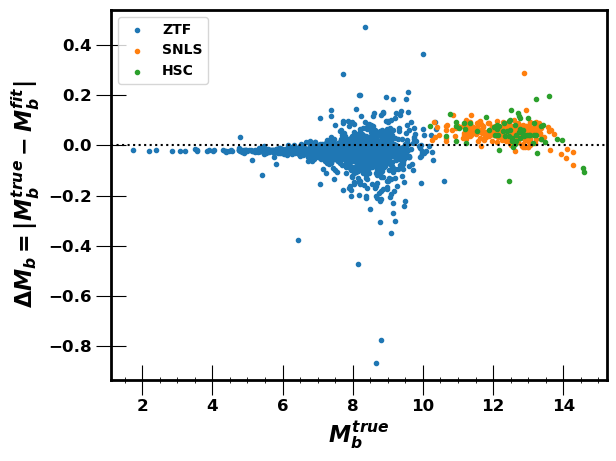

In [17]:
for s in nacl_fit.survey.unique():
    plt.scatter(-2.5*np.log10(nacl_fit[nacl_fit.survey==s].x0_init),
                -2.5*np.log10(nacl_fit[nacl_fit.survey==s].x0_init) - -2.5*np.log10(nacl_fit[nacl_fit.survey==s].x0),
                marker='.', color=survey_colors[s], label=s)
plt.axhline(0, linestyle=':', color='k')
plt.xlabel(r'$M_b^{true}$')
plt.legend()
plt.ylabel(r'$\Delta M_b = |M_b^{true} - M_b^{fit}|$')
plt.savefig('/cfs/data/angi0819/Projet_LPNHE/figures/nacl_lcfit/Mb.png')

Text(0, 0.5, '$\\Delta M_b = |M_b^{true} - M_b^{fit}|$')

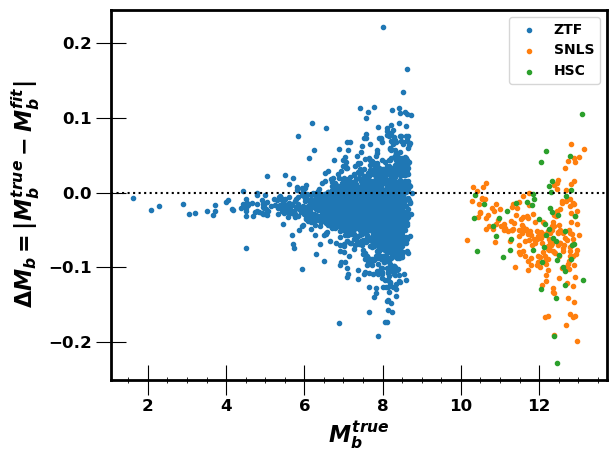

In [48]:
for s in nacl_fit.survey.unique():
    filt = (nacl_fit.survey==s) & nacl_fit.valid
    plt.scatter(nacl_fit[filt].mu_init,
                nacl_fit[filt].mu_init - nacl_fit[filt].mu,
                marker='.', color=survey_colors[s], label=s)
plt.axhline(0, linestyle=':', color='k')
plt.xlabel(r'$M_b^{true}$')
plt.legend()
plt.ylabel(r'$\Delta M_b = |M_b^{true} - M_b^{fit}|$')


In [50]:
(nacl_fit[nacl_fit.valid].mu_init - nacl_fit[nacl_fit.valid].mu).mean()

-0.025491375372567703

In [167]:
from edris.cosmo import Tcmb_to_Omega_gamma, mu
Tcmb = 2.7255
def flcdm(params, explanatory):
    p = {'Omega_m': params['Omega_m'],
         'Tcmb': Tcmb,
         'Omega_b_h2': 0.02204854,
         'Omega_k': 0.,
         'w': -1.,
         'H0': 68.1,
         'm_nu': 0.06,
         'Neff': 3.046
         }

    return mu(p, explanatory['z']) + params['M0']


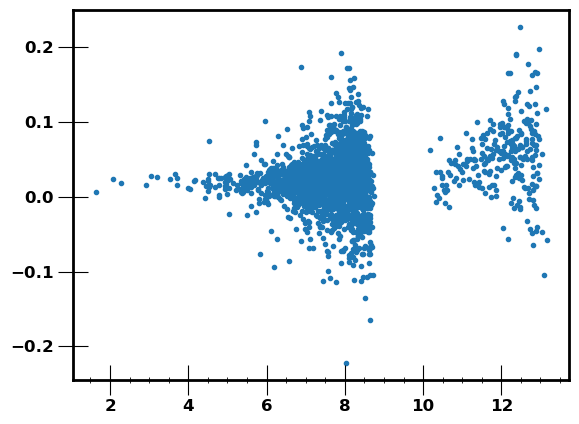

In [224]:
plt.scatter(nacl_fit[nacl_fit.valid].mu_init, nacl_fit[nacl_fit.valid].mu-nacl_fit[nacl_fit.valid].mu_init, marker='.')

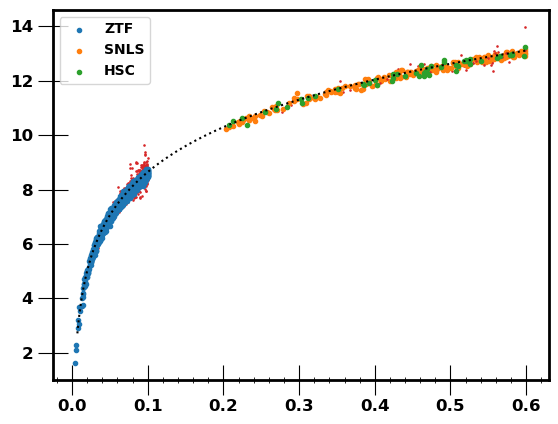

In [225]:
for s in nacl_fit.survey.unique():
    filt = (nacl_fit.survey==s) & (~nacl_fit.valid)
    plt.scatter(nacl_fit[filt].z, nacl_fit[filt].mu,
                s=3, color='tab:red', marker=".")
    filt = (nacl_fit.survey==s) & (nacl_fit.valid)
    plt.scatter(nacl_fit[filt].z, nacl_fit[filt].mu,
                color=survey_colors[s], marker=".", label=s)

z=jnp.linspace(7e-3, 0.6, 1000)
plt.plot(z, flcdm(edris_res['res'], {"z":z}), ':k')
# plt.plot(z, flcdm(x0, {"z":z}), ':r')
plt.legend()

In [226]:
use_vpec = nacl_fit[nacl_fit.valid & (nacl_fit.z > 7e-3) & (nacl_fit.survey=='ZTF')]

In [241]:
use_vpec['z_cosmo'] = data.loc[use_vpec.sn, "z_cosmo"]

2025-03-26 17:10:48 WARNING py.warnings - /tmp/ipykernel_20307/723749088.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_vpec['z_cosmo'] = data.loc[use_vpec.sn, "z_cosmo"]



In [227]:
z=np.linspace(7e-3, 0.3, 10000)
mag_to_z = interp1d(
    flcdm(edris_res['res'], {"z":z}), z
)
z_cosmo_salt = mag_to_z(use_vpec.mu)

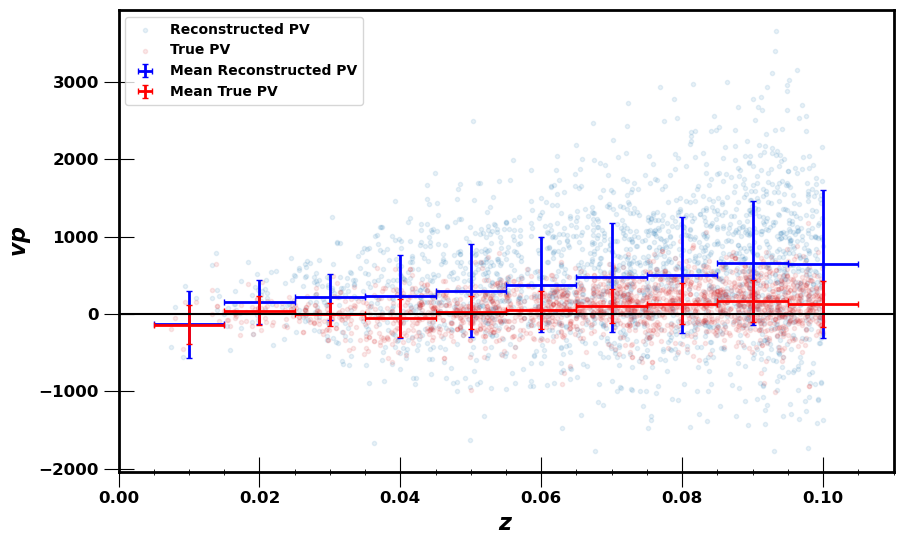

In [242]:
true_pv = (use_vpec.z - use_vpec.z_cosmo) * c * 1e-3 / (1 + use_vpec.z_cosmo)
edris_pv = (use_vpec.z - z_cosmo_salt) * c * 1e-3 / (1 + z_cosmo_salt)

z_max = 0.1
n_bins = 10
bounds = np.linspace(0.00, z_max, n_bins + 1)
width = z_max / n_bins
in_bins = [(use_vpec.z > z_min) & (use_vpec.z < z_min + width) for z_min in bounds]
plt.figure(figsize=(10, 6))

plt.scatter(use_vpec.z, edris_pv, marker=".", alpha=0.1, label="Reconstructed PV")
plt.scatter(use_vpec.z, true_pv, marker=".", color="tab:red", alpha=0.1, label="True PV")

plt.errorbar(
    bounds + width,
    [edris_pv[b_].mean() for b_ in in_bins],
    yerr=[edris_pv[b_].std() for b_ in in_bins],
    xerr=width / 2,
    linestyle="",
    color="blue",
    linewidth=2,
    capsize=2,
    label="Mean Reconstructed PV",
)

plt.errorbar(
    bounds + width,
    [true_pv[b_].mean() for b_ in in_bins],
    yerr=[true_pv[b_].std() for b_ in in_bins],
    xerr=width / 2,
    linestyle="",
    color="red",
    linewidth=2,
    capsize=2,
    label="Mean True PV",
)

plt.xlabel("$z$")
plt.ylabel("$vp$")
plt.legend()
plt.axhline(0, color="k")

# EDRIS

Attention, Uchuu avec Planck15, Abacus avec Planck18

In [ ]:
from astropy.cosmology import Planck15, Planck18

# cosmo = Planck15

In [ ]:
from edris.cosmo import dL, Tcmb_to_Omega_gamma, Tcmb, mu

In [ ]:
def flcdm(params, explanatory):
    p = {
        "Omega_m": params["Omega_m"],
        "Omega_gamma": cosmo.Ogamma0,
        "w": -1.0,
        "H0": params["H0"],
        "Omega_k": cosmo.Ok0,
    }
    return mu(p, explanatory["z"]) - 19.3

In [ ]:
params = dict(
    H0=jnp.array([cosmo.H0.value]),
    Omega_m=jnp.array([cosmo.Om0]),
    Omega_gamma=jnp.array([cosmo.Ogamma0]),
    Omega_k=jnp.array([cosmo.Ok0]),
    w=jnp.array([-1.0]),
    coef=jnp.array([-0.14, 3.15]),
    sigma_int=jnp.array([jnp.array([0.1])]),
)

In [ ]:
source = sncosmo.get_source("salt2", version="2.4")
model = sncosmo.Model(
    source=source,
    effects=[sncosmo.CCM89Dust()],
    effect_names=["mw"],
    effect_frames=["obs"],
)

In [ ]:
with open("outdir/ztf_2M++_snls_hsc.pkl", "rb") as file:
    values = pickle.load(file)
    covs = pickle.load(file)

In [ ]:
values = values[values.valid].copy()
data_ztf,_ = load_from_skysurvey('./data/dataset_2M++.pkl', survey='ZTF')
data_hsc,_ = load_from_skysurvey('./data/dataset_hsc.pkl', survey='HSC')
data_snls,_ = load_from_skysurvey('./data/dataset_snls.pkl', survey='SNLS')
data=pandas.concat([data_ztf, data_hsc, data_snls])
values = values.join(data[['ra','dec']])
values.ra = (values.ra/180-1)*np.pi
values.dec = values.dec/180*np.pi
values["rcom"] = cosmo.comoving_distance(values.z).value

In [ ]:
from scipy.linalg import block_diag

full_matrix = block_diag(*[covs[i] for i in values.index])
n = len(values)
full_cov_sorted = full_matrix[
    :,
    [
        *[3 * i for i in range(n)],
        *[3 * i + 1 for i in range(n)],
        *[3 * i + 2 for i in range(n)],
    ],
][
    [
        *[3 * i for i in range(n)],
        *[3 * i + 1 for i in range(n)],
        *[3 * i + 2 for i in range(n)],
    ],
    :,
]

In [ ]:
from matplotlib.colors import SymLogNorm

plt.imshow(
    jnp.diag(1 / jnp.sqrt(jnp.diag(full_cov_sorted)))
    @ full_cov_sorted
    @ jnp.diag(1 / jnp.sqrt(jnp.diag(full_cov_sorted))),
    norm=SymLogNorm(vmin=-1, vmax=1, linthresh=1e-6),
)
plt.colorbar()

In [ ]:
values["survey"] = values.index.map(lambda s: s.split("_")[0])

In [ ]:
k, p = np.loadtxt('./data/power_spectrum.txt')

from flip import covariance, utils
coordinates = np.array([values['ra'],
                        values['dec'],
                        values['rcom']])
sigmau_fiducial = 15

power_spectrum_dict = {"vv": [[k, p * utils.Du(k, sigmau_fiducial) ** 2]]}

size_batch=10_000
number_worker=64

covariance_fit = covariance.CovMatrix.init_from_flip(
    "carreres23",
    "velocity",
    power_spectrum_dict,
    coordinates_velocity=coordinates,
    size_batch=size_batch,
    number_worker=number_worker,
)

covariance_fit.compute_full_matrix()
vpec_cov = (5/(c.value*1e-3*np.log(10)))**2*covariance_fit.covariance_dict['vv'][0] * \
            (np.array([1/values.z.values]).T @ \
             np.array([1/values.z.values]))
from matplotlib.colors import SymLogNorm
plt.figure(figsize=(7,7))
plt.imshow(vpec_cov, norm=SymLogNorm(linthresh=1e-7))
plt.colorbar(label=r'$mag^2$')
plt.title(r"$Cov_{mm}$")

In [ ]:
filt = (
    (values.c < 0.3) # & (values.err_x1 + np.abs(values.x1) < 5) & (values.err_c < 0.05)
)  # &\
# ((values.survey != 'ZTF') | (values.z < 0.1))
sum(filt)

In [ ]:
surveys = set(values[filt]["survey"])
survey_map = dict(zip(surveys, range(len(surveys))))
survey_id = jnp.array([survey_map[s] for s in values[filt]["survey"]])

In [ ]:
obs = Obs(
    mag=jnp.array(values[filt].magobs),
    variables=jnp.hstack([jnp.array(values[filt].x1), jnp.array(values[filt].c)]),
)

In [ ]:
exp = dict(
    z=jnp.array(values[filt].z),
    survey_id=survey_id,
    survey_map=survey_map,
)

In [ ]:
n = len(values)

In [ ]:
cov = FullCovariance(
    full_cov_sorted[:n, :n] + vpec_cov, full_cov_sorted[n:, n:], full_cov_sorted[:n, n:]
)

In [ ]:
cov = cov.select(filt.values)

In [ ]:
exp["map_survey"] = {
    v: k for v, k in zip(exp["survey_map"].values(), exp["survey_map"].keys())
}

In [ ]:
x0 = dict(
    H0=jnp.array([cosmo.H0.value]),
    Omega_m=jnp.array([cosmo.Om0]),
    coef=jnp.array([-0.14, 3.15]),
    variables=jnp.array(obs.variables.reshape((2, -1))),
    sigma_int=jnp.array([0.1]),
)

In [ ]:
for survey in exp["survey_map"].keys():
    plt.scatter(
        exp["z"][exp["survey_id"] == exp["survey_map"][survey]],
        obs.mag[
            exp["survey_id"] == exp["survey_map"][survey]
        ],  # - jnp.matmul(x0["coef"], obs.variables.reshape(2,-1)),
        c=survey_colors[survey],
        marker=".",
        label=survey,
    )

plt.plot(
    np.linspace(1e-3, 1, 1000),
    flcdm(params, {"z": jnp.linspace(5e-3, 1, 1000)}),
    linestyle=":",
    color="k",
    label="Planck 2015",
)
plt.xlabel(r"$z$")
plt.ylabel(r"$\mu$")
plt.legend()

In [ ]:
for survey in exp["survey_map"].keys():
    plt.scatter(
        exp["z"][exp["survey_id"] == exp["survey_map"][survey]],
        obs.mag[exp["survey_id"] == exp["survey_map"][survey]]
        - flcdm(params, {"z": exp["z"][exp["survey_id"] == exp["survey_map"][survey]]}),
        # - jnp.matmul(x0["coef"], obs.variables.reshape(2,-1)),
        c=survey_colors[survey],
        marker=".",
        label=survey,
    )

plt.axhline(0, linestyle=":", color="k", label="Planck 15")
plt.xlabel(r"$z$")
plt.ylabel(r"$\mu$")
plt.legend()

In [ ]:
fig, (ax_mm, ax_mx, ax_xx) = plt.subplots(ncols = 3, figsize=(15,4))
im_mm = ax_mm.imshow(jnp.diag(1 / jnp.sqrt(jnp.diag(cov.C_mm))) @ cov.C_mm @ jnp.diag(1 / jnp.sqrt(jnp.diag(cov.C_mm))), norm=SymLogNorm(linthresh=1e-3), cmap="RdBu")
plt.colorbar(im_mm, ax=ax_mm)
im_mx = ax_mx.imshow(jnp.diag(1 / jnp.sqrt(jnp.diag(cov.C_mm))) @ cov.C_mx @ jnp.diag(1 / jnp.sqrt(jnp.diag(cov.C_xx))), norm=SymLogNorm(linthresh=1e-3), cmap="RdBu")
plt.colorbar(im_mx, ax=ax_mx)
im_xx = ax_xx.imshow(jnp.diag(1 / jnp.sqrt(jnp.diag(cov.C_xx))) @ cov.C_xx @ jnp.diag(1 / jnp.sqrt(jnp.diag(cov.C_xx))), norm=SymLogNorm(linthresh=1e-3), cmap="RdBu")
plt.colorbar(im_xx, ax=ax_xx)


In [ ]:
L = lambda x: likelihood(
    x, exp, cov, obs, cosmo=flcdm, truncated=False, restricted=False
)

In [ ]:
L(x0)

In [ ]:
fit_params = dict(niter=1000, lmbda=1e4, tol=1e-3, max_iter_tncg=None, verbose=True)

In [ ]:
res, loss, lmbda, iter_params = tncg(L, x0, **fit_params)

In [ ]:
jax.tree.map(lambda x, y: x - y, res, x0)

In [ ]:
hess = jax.hessian(L)(res)

In [ ]:
n = {k1: hess[k1][k1].shape[1] for k1 in hess.keys()}
n["variables"] *= n["coef"]
flatten_hess = jnp.vstack(
    [
        np.hstack([hess[k1][k2].reshape(n[k1], n[k2]) for k2 in hess.keys()])
        for k1 in hess.keys()
    ]
)
cov_res = jnp.linalg.inv(0.5 * flatten_hess)

In [ ]:
with open("outdir/edris_2M++_snls_hsc.pkl", "wb") as file:
    pickle.dump(obs, file)
    pickle.dump(exp, file)
    pickle.dump(cov, file)
    pickle.dump(res, file)
    pickle.dump(cov_res, file)

In [ ]:
from matplotlib.colors import SymLogNorm

plt.imshow(cov_res, norm=SymLogNorm(linthresh=1e-6, vmin=-1, vmax=1), cmap="RdBu")
plt.colorbar()

In [ ]:
potential_keys = ["H0", "M0", "Omega_m", "Omega_r", "Omega_l", "coef", "sigma_int"]
latex_keys = {
    "H0": "$H_0$",
    "M0": "$M_0$",
    "Omega_m": "$\\Omega_m$",
    "Omega_r": "$\\Omega_r$",
    "Omega_l": "$\\Omega_l$",
    "coef": ["$\\alpha$", "$\\beta$"],
    "sigma_int": "$\\sigma_{int}$",
    "alpha": "$\\alpha$",
    "beta": "$\\beta$",
}

In [ ]:
plt.rc("axes", labelsize=20)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=14)  # fontsize of the tick labels
plt.rc("ytick", labelsize=14)  # fontsize of the tick labels
plt.rc("legend", fontsize=12)  # legend fontsize

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
keys = np.array(list(res.keys()))[[p in potential_keys for p in res.keys()]]
_labels, _values, _diffs = [], [], []
for k in keys:
    _labels += latex_keys[k] if isinstance(latex_keys[k], list) else [latex_keys[k]]
    _values += list(res[k])
    _diffs += list(res[k] - x0[k])
n_pars = len(keys)
ax.hlines(0, -1, 5 * n_pars + 1, color="r", linestyle=":")
ax.set_xticks(5 * np.arange(n_pars + 1), _labels)
ax.set_ylabel("Deviation")
plt.errorbar(
    5 * np.arange(n_pars + 1),
    _diffs,
    yerr=jnp.sqrt(jnp.diag(cov_res)[: n_pars + 1]),
    linestyle="",
    marker=".",
    capsize=5,
    capthick=0.5,
)
# plt.savefig('../figures/Uchuu_final_params.png')
fig, ax = plt.subplots(figsize=(1, 1))
ax.axis("off")
for i, pos in enumerate(np.arange(n_pars + 1) * 0.4):
    fig.text(
        0,
        pos,
        _labels[i] + f" = {_values[i]:.3f} $\\pm$ {jnp.sqrt(jnp.diag(cov_res)[i]):.3f}",
    )

In [ ]:
def plot_hubble(obs, res, cov_res, cosmo, x0):
    std_mag = obs.mag - jnp.matmul(res["coef"], res["variables"])

    fig, (ax1, ax2) = plt.subplots(
        nrows=2, sharex="col", figsize=(7, 6), gridspec_kw={"height_ratios": [3, 1]}
    )
    ax1.set_xscale("log")
    ax1.scatter(
        exp["z"], std_mag, s=0.5, alpha=0.3, color="k", label="Standardised magnitudes"
    )
    ax1.plot(
        np.linspace(5e-3, 1.2, 1000),
        cosmo(x0, {"z": np.linspace(5e-3, 1.2, 1000)}),
        color="tab:green",
        linestyle=":",
        label="Underlying cosmo",
    )

    ax2.scatter(exp["z"], std_mag - cosmo(x0, exp), color="k", s=0.5, alpha=0.3)

    if "mu_bins" in res.keys():
        ax1.errorbar(
            exp["z_bins"],
            res["mu_bins"],
            yerr=jnp.sqrt(jnp.diag(cov_res[2 : 2 + n_bins, 2 : 2 + n_bins])),
            color="tab:blue",
            label="edris",
        )
        ax2.errorbar(
            exp["z_bins"],
            res["mu_bins"] - cosmo(x0, {"z": exp["z_bins"]}),
            yerr=jnp.sqrt(jnp.diag(cov_res[2 : 2 + n_bins, 2 : 2 + n_bins])),
            color="tab:blue",
        )
    else:
        ax1.plot(
            jnp.linspace(5e-3, 1.2, 1000),
            cosmo(res, {"z": jnp.linspace(5e-3, 1.2, 1000)}),
            color="tab:blue",
            label="edris",
        )
        ax2.plot(
            jnp.linspace(5e-3, 1.2, 1000),
            cosmo(res, {"z": jnp.linspace(5e-3, 1.2, 1000)})
            - cosmo(x0, {"z": jnp.linspace(5e-3, 1.2, 1000)}),
            color="tab:blue",
        )

    ax1.legend()
    ax1.set_ylabel(r"$\mu$")

    lims = ax2.get_xlim()
    ax2.hlines(0.0, xmin=lims[0], xmax=lims[1], color="tab:green", linestyle=":")
    ax2.set_xlim(*lims)
    ax2.set_ylabel(r"$\Delta\mu$")
    ax2.set_xlabel(r"$z$")

    fig.suptitle(r"Modèle fitté par Edris")

In [ ]:
plot_hubble(obs, res, cov_res, flcdm, x0)

In [ ]:
mag_to_z = interp1d(
    flcdm(res, {"z": np.linspace(2e-3, 0.3, 10000)}), np.linspace(2e-3, 0.3, 10000)
)
z_cosmo_salt = mag_to_z(
    obs.mag[exp["survey_id"] == exp["survey_map"]["ZTF"]]
    - jnp.matmul(res["coef"], res["variables"])[
        exp["survey_id"] == exp["survey_map"]["ZTF"]
    ]
)

In [ ]:
data_ztf = data[data.index.isin(values[(values.survey == "ZTF") & filt].index)]
true_pv = (data_ztf.z - data_ztf.z_cosmo) * c * 1e-3 / (1 + data_ztf.z_cosmo)
edris_pv = (data_ztf.z - z_cosmo_salt) * c * 1e-3 / (1 + z_cosmo_salt)

z_max = 0.1
n_bins = 10
bounds = np.linspace(0.00, z_max, n_bins + 1)
width = z_max / n_bins
in_bins = [(data_ztf.z > z_min) & (data_ztf.z < z_min + width) for z_min in bounds]
plt.figure(figsize=(10, 6))

plt.scatter(data_ztf.z, edris_pv, marker=".", alpha=0.1, label="Reconstructed PV")
plt.scatter(
    data_ztf.z, true_pv, marker=".", color="tab:red", alpha=0.1, label="True PV"
)

plt.errorbar(
    bounds + width,
    [edris_pv[b_].mean() for b_ in in_bins],
    yerr=[edris_pv[b_].std() for b_ in in_bins],
    xerr=width / 2,
    linestyle="",
    color="blue",
    linewidth=2,
    capsize=2,
    label="Mean Reconstructed PV",
)

plt.errorbar(
    bounds + width,
    [true_pv[b_].mean() for b_ in in_bins],
    yerr=[true_pv[b_].std() for b_ in in_bins],
    xerr=width / 2,
    linestyle="",
    color="red",
    linewidth=2,
    capsize=2,
    label="Mean True PV",
)

plt.xlabel("$z$")
plt.ylabel("$vp$")
plt.legend()
plt.axhline(0, color="k")

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(
    data_ztf.z,
    true_pv - edris_pv,
    marker=".",
    linestyle="",
    alpha=0.3,
    label="$vp_{vraie} - vp_{edris}$",
)
plt.errorbar(
    bounds + width,
    [(true_pv - edris_pv)[b_].mean() for b_ in in_bins],
    yerr=[(true_pv - edris_pv)[b_].std() for b_ in in_bins],
    xerr=width / 2,
    linestyle="",
    color="blue",
    linewidth=2,
    capsize=2,
    label="PV residuals",
)
plt.xlabel("$z$")
plt.ylabel(r"$\Delta pv$")
plt.axhline(0, color="k")
plt.axhline((true_pv - edris_pv).values.mean(), color="r", linestyle=":", label="Mean")
plt.axhline(
    (true_pv - edris_pv).values.mean() + (true_pv - edris_pv).values.std(),
    color="r",
    linestyle="--",
    label="std",
)
plt.axhline(
    (true_pv - edris_pv).values.mean() - (true_pv - edris_pv).values.std(),
    color="r",
    linestyle="--",
)

plt.legend()

In [ ]:
(true_pv - edris_pv).values.mean(), (true_pv - edris_pv).values.std()

# Power spectrum stuff

In [ ]:
from cosmoprimo import *
cosmo_p = Cosmology(engine='camb')
cosmo_planck = fiducial.Planck2018FullFlatLCDM()

In [ ]:
fo = Fourier(cosmo_p, engine='class')
pk = fo.pk_interpolator()
k = np.logspace(-6, 2, 1000)
z = 0
plt.loglog(k, pk(k, z=z), label='class')
fo_camb = cosmo_p.get_fourier(engine='camb') # second initialisation style
pk = fo_camb.pk_interpolator() # same number of cells are output than in CLASS
plt.loglog(k, pk(k, z=z), label='camb')
# cross density-velocity CDM + baryon power spectrum
plt.loglog(k,fo.pk_interpolator(of=('theta_cb', 'theta_cb'))(k, z=z), label=r'$P_{\delta_{cb}\theta_{cb}}$')
plt.loglog(k,fo.pk_interpolator(of=('theta_m', 'theta_m'))(k, z=z), label=r'$P_{\theta_{m}\theta_{m}}$')
plt.xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.legend()
plt.show()

In [ ]:
k, p = np.loadtxt('test')

In [ ]:
with open("./outdir/ztf_2M++_snls_hsc_DR2cuts.pkl", "rb") as file:
    values=pickle.load(file)
    covs=pickle.load(file)

In [ ]:
data_ztf,_ = load_from_skysurvey('./data/dataset_2M++.pkl', survey='ZTF')
data_hsc,_ = load_from_skysurvey('./data/dataset_hsc.pkl', survey='HSC')
data_snls,_ = load_from_skysurvey('./data/dataset_snls.pkl', survey='SNLS')
data=pandas.concat([data_ztf, data_hsc, data_snls])

In [ ]:
values = values.join(data[['ra','dec']])
values.ra = (values.ra/180-1)*np.pi
values.dec = values.dec/180*np.pi

In [ ]:
values["rcom"] = cosmo.comoving_distance(values.z).value
values.sort_values('z', inplace=True)

In [ ]:
from flip import covariance, utils
coordinates = np.array([values['ra'],
                        values['dec'],
                        values['rcom']])
sigmau_fiducial = 15

power_spectrum_dict = {"vv": [[k, p * utils.Du(k, sigmau_fiducial) ** 2]]}

size_batch=10_000
number_worker=64

covariance_fit = covariance.CovMatrix.init_from_flip(
    "carreres23",
    "velocity",
    power_spectrum_dict,
    coordinates_velocity=coordinates,
    size_batch=size_batch,
    number_worker=number_worker,
)


In [ ]:
covariance_fit.compute_full_matrix()

In [ ]:
vpec_cov = (5/(c.value*1e-3*np.log(10)))**2*covariance_fit.covariance_dict['vv'][0] * \
            (np.array([1/values.z.values]).T @ \
             np.array([1/values.z.values]))

In [ ]:
from matplotlib.colors import SymLogNorm
fig, (ax_vv, ax_mm) = plt.subplots(figsize=(12,5), ncols=2)
im_vv = ax_vv.imshow(covariance_fit.covariance_dict['vv'][0], norm=SymLogNorm(linthresh=1e3))
plt.colorbar(im_vv, ax=ax_vv, label=r'$(km/s)^2$')
ax_vv.set_title(r'$Cov_{vv}$')
im_mm = ax_mm.imshow(vpec_cov, norm=SymLogNorm(linthresh=1e-7))
plt.colorbar(im_mm, ax=ax_mm, label=r'$mag^2$')
ax_mm.set_title(r"$Cov_{mm}$")

In [ ]:
plt.scatter(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]],
            true_pv[filt] - edris_vp,
            marker=".",
            linestyle='',
            alpha=0.3,
            label="$vp_{vraie} - vp_{edris}$")
mean_delta = [(true_pv[filt] - edris_vp).values[(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] > z_min) & \
                                         (exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] < z_min + 0.01)].mean()
              for z_min in np.linspace(0.00, 0.05, 6)]
err_delta = [(true_pv[filt] - edris_vp).values[(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] > z_min) & \
                                        (exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] < z_min + 0.01)].std()
             for z_min in np.linspace(0.00, 0.05, 6)]
plt.errorbar(np.linspace(0.00, 0.05, 6)+0.005,
             mean_delta,
             yerr=err_delta,
             xerr=0.005,
             linestyle='',
             color='tab:red',
             linewidth=2,
             capsize=2,
             label="Moyenne")

plt.xlabel("$z$")
plt.ylabel("$\Delta vp$")
plt.legend()
plt.ylim(-4000,4000)
plt.axhline(0, color='k')

In [ ]:
(true_pv[filt] - edris_vp).values.mean()